
# 주거실거래정보 데이터 로딩 및 기본 정보 확인

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
from scipy import stats
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import joblib
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False



In [1]:




# 데이터 로딩
print("="*50)
print("주거실거래정보 데이터 로딩 및 기본 정보 확인")
print("="*50)

# 데이터 파일 경로
data_path = "../data/주거실거래정보.csv"

try:
    # 다양한 인코딩으로 시도
    encodings = ['utf-8']
    df = None
    
    for encoding in encodings:
        try:
            print(f"인코딩 {encoding}으로 데이터 로딩 시도...")
            df = pd.read_csv(data_path, encoding=encoding)
            print(f"성공: {encoding} 인코딩으로 데이터 로딩 완료")
            break
        except UnicodeDecodeError:
            print(f"실패: {encoding} 인코딩으로 로딩 불가")
            continue
    
    if df is None:
        raise Exception("모든 인코딩으로 데이터 로딩 실패")
    
    # 기본 정보 출력
    print("\n1. 데이터 기본 정보")
    print("-" * 30)
    print(f"데이터 형태: {df.shape}")
    print(f"컬럼 수: {len(df.columns)}")
    print(f"행 수: {len(df)}")
    
    print("\n2. 컬럼 정보")
    print("-" * 30)
    print("컬럼명 목록:")
    for i, col in enumerate(df.columns, 1):
        print(f"{i:2d}. {col}")
    
    print("\n3. 데이터 타입 정보")
    print("-" * 30)
    print(df.dtypes)
    
    print("\n4. 첫 5행 데이터 확인")
    print("-" * 30)
    print(df.head())
    
    print("\n5. 결측치 정보")
    print("-" * 30)
    missing_info = df.isnull().sum()
    missing_percent = (df.isnull().sum() / len(df)) * 100
    missing_df = pd.DataFrame({
        '결측치 수': missing_info,
        '결측치 비율(%)': missing_percent
    })
    print(missing_df[missing_df['결측치 수'] > 0])
    
    print("\n6. 기본 통계 정보")
    print("-" * 30)
    print(df.describe())
    
    
    # 데이터 저장 (후속 분석용)
    print("\n데이터 저장")
    print("-" * 30)
    df.to_pickle("../data/housing_data_cleaned.pkl")
    print("데이터가 housing_data_cleaned.pkl로 저장되었습니다.")
    
    print("\n데이터 로딩 및 기본 정보 확인 완료!")
    
except Exception as e:
    print(f"오류 발생: {e}")
    print("데이터 로딩에 실패했습니다.") 

주거실거래정보 데이터 로딩 및 기본 정보 확인
인코딩 utf-8으로 데이터 로딩 시도...
성공: utf-8 인코딩으로 데이터 로딩 완료

1. 데이터 기본 정보
------------------------------
데이터 형태: (1538030, 22)
컬럼 수: 22
행 수: 1538030

2. 컬럼 정보
------------------------------
컬럼명 목록:
 1. NO
 2. 시군구
 3. 번지
 4. 본번
 5. 부번
 6. 단지명
 7. 전월세구분
 8. 전용면적(㎡)
 9. 계약년월
10. 계약일
11. 보증금(만원)
12. 월세금(만원)
13. 층
14. 건축년도
15. 도로명
16. 계약기간
17. 계약구분
18. 갱신요구권 사용
19. 종전계약 보증금(만원)
20. 종전계약 월세(만원)
21. 주택유형
22. 건물명

3. 데이터 타입 정보
------------------------------
NO                int64
시군구              object
번지               object
본번                int64
부번                int64
단지명              object
전월세구분            object
전용면적(㎡)         float64
계약년월              int64
계약일               int64
보증금(만원)          object
월세금(만원)          object
층                 int64
건축년도              int64
도로명              object
계약기간             object
계약구분             object
갱신요구권 사용         object
종전계약 보증금(만원)     object
종전계약 월세(만원)      object
주택유형             object
건물명              object
d

# 데이터 전처리 및 생활비 관련 파생 변수 생성

In [3]:
print("="*60)
print("주거실거래정보 데이터 전처리 및 파생 변수 생성")
print("="*60)

# 저장된 데이터 로딩
try:
    df = pd.read_pickle("../data/housing_data_cleaned.pkl")
    print(f"데이터 로딩 완료: {df.shape}")
except:
    print("이전 단계에서 저장된 데이터가 없습니다. 직접 로딩합니다.")
    df = pd.read_csv("../data/주거실거래정보.csv", encoding='utf-8')

# 1. 데이터 전처리
print("\n1. 데이터 전처리 시작")
print("-" * 40)

# 1-1. 보증금, 월세금 컬럼 전처리 (문자열에서 숫자로 변환)
def clean_money_column(col):
    """보증금, 월세금 컬럼의 쉼표 제거 및 숫자 변환"""
    if col.dtype == 'object':
        # 쉼표 제거하고 NaN이 아닌 값들만 처리
        cleaned = col.astype(str).str.replace(',', '').str.replace(' ', '')
        # 숫자가 아닌 값들을 NaN으로 처리
        cleaned = pd.to_numeric(cleaned, errors='coerce')
        return cleaned
    return col

# 보증금, 월세금 컬럼 전처리
money_columns = ['보증금(만원)', '월세금(만원)', '종전계약 보증금(만원)', '종전계약 월세(만원)']
for col in money_columns:
    if col in df.columns:
        df[col] = clean_money_column(df[col])
        print(f"{col} 컬럼 전처리 완료")

# 1-2. 계약년월 전처리 (YYYYMM -> datetime)
df['계약년월_str'] = df['계약년월'].astype(str)
df['계약년'] = df['계약년월_str'].str[:4].astype(int)
df['계약월'] = df['계약년월_str'].str[4:].astype(int)
df['계약일자'] = pd.to_datetime(df['계약년월_str'] + '01', format='%Y%m%d', errors='coerce')
print("계약년월 컬럼 전처리 완료")

# 1-3. 시군구 정보 분리 및 정제
def extract_location_info(address):
    """주소에서 시도, 시군구, 읍면동 정보 추출"""
    if pd.isna(address):
        return pd.Series([None, None, None, None])
    
    # 기본 패턴 매칭
    pattern = r'(.*?)\s+(.*?)\s+(.*)'
    match = re.match(pattern, str(address))
    
    if match:
        sido = match.group(1).strip()
        sigungu = match.group(2).strip()
        eupmyeondong = match.group(3).strip()
        
        # 특별시/광역시 처리
        if '특별시' in sido or '광역시' in sido:
            full_sigungu = sigungu
        else:
            full_sigungu = f"{sido} {sigungu}"
            
        return pd.Series([sido, sigungu, eupmyeondong, full_sigungu])
    else:
        return pd.Series([address, None, None, address])

# 주소 정보 분리
location_info = df['시군구'].apply(extract_location_info)
df[['시도', '구_시군구', '읍면동', '전체_시군구']] = location_info
print("주소 정보 분리 완료")

# 2. 생활비 관련 파생 변수 생성
print("\n2. 생활비 관련 파생 변수 생성")
print("-" * 40)

# 2-1. 월 주거비 계산 (전월세 구분에 따른 월 주거비 계산)
def calculate_monthly_housing_cost(row):
    """월 주거비 계산 함수"""
    deposit = row['보증금(만원)'] if not pd.isna(row['보증금(만원)']) else 0
    monthly_rent = row['월세금(만원)'] if not pd.isna(row['월세금(만원)']) else 0
    
    if row['전월세구분'] == '전세':
        # 전세의 경우: 보증금의 연 3% 이자를 월로 환산
        return deposit * 0.03 / 12
    elif row['전월세구분'] == '월세':
        # 월세의 경우: 보증금의 연 3% 이자 + 월세
        return (deposit * 0.03 / 12) + monthly_rent
    else:
        return np.nan

df['월_주거비'] = df.apply(calculate_monthly_housing_cost, axis=1)
print("월 주거비 계산 완료")

# 2-2. 평당 가격 계산
df['평당_가격'] = df['월_주거비'] / (df['전용면적(㎡)'] * 0.3025)  # ㎡를 평으로 환산
print("평당 가격 계산 완료")

# 2-3. 건물 노후도 계산
current_year = 2024
df['건물_노후도'] = current_year - df['건축년도']
print("건물 노후도 계산 완료")

# 2-4. 주거비 부담 수준 분류
def classify_housing_cost_level(cost):
    """주거비 수준 분류 함수"""
    if pd.isna(cost):
        return '미분류'
    elif cost <= 30:
        return '저렴'
    elif cost <= 80:
        return '보통'
    elif cost <= 150:
        return '비싼'
    else:
        return '매우비싼'

df['주거비_수준'] = df['월_주거비'].apply(classify_housing_cost_level)
print("주거비 수준 분류 완료")

# 2-5. 지역별 주거비 통계 생성
region_stats = df.groupby('전체_시군구').agg({
    '월_주거비': ['mean', 'median', 'std', 'count'],
    '전용면적(㎡)': ['mean', 'median'],
    '건물_노후도': ['mean', 'median'],
    '평당_가격': ['mean', 'median']
}).round(2)

# 컬럼명 정리
region_stats.columns = ['_'.join(col).strip() for col in region_stats.columns]
region_stats = region_stats.reset_index()
print("지역별 주거비 통계 생성 완료")

# 3. 데이터 품질 확인
print("\n3. 데이터 품질 확인")
print("-" * 40)

# 3-1. 이상치 탐지 및 처리
def detect_outliers_iqr(df, column):
    """IQR 방법으로 이상치 탐지"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# 주요 변수들의 이상치 확인
outlier_columns = ['월_주거비', '전용면적(㎡)', '평당_가격']
outlier_summary = {}

for col in outlier_columns:
    if col in df.columns:
        outliers, lower, upper = detect_outliers_iqr(df, col)
        outlier_summary[col] = {
            '이상치_개수': len(outliers),
            '이상치_비율': len(outliers) / len(df) * 100,
            '하한': lower,
            '상한': upper
        }
        print(f"{col}: 이상치 {len(outliers)}개 ({len(outliers) / len(df) * 100:.2f}%)")

# 3-2. 결측치 처리 방안 수립
missing_analysis = df.isnull().sum()
missing_percent = (missing_analysis / len(df)) * 100
missing_df = pd.DataFrame({
    '결측치_수': missing_analysis,
    '결측치_비율': missing_percent
}).sort_values('결측치_비율', ascending=False)

print("\n결측치 현황:")
print(missing_df[missing_df['결측치_수'] > 0])

주거실거래정보 데이터 전처리 및 파생 변수 생성
데이터 로딩 완료: (1538030, 22)

1. 데이터 전처리 시작
----------------------------------------
보증금(만원) 컬럼 전처리 완료
월세금(만원) 컬럼 전처리 완료
종전계약 보증금(만원) 컬럼 전처리 완료
종전계약 월세(만원) 컬럼 전처리 완료
계약년월 컬럼 전처리 완료
주소 정보 분리 완료

2. 생활비 관련 파생 변수 생성
----------------------------------------
월 주거비 계산 완료
평당 가격 계산 완료
건물 노후도 계산 완료
주거비 수준 분류 완료
지역별 주거비 통계 생성 완료

3. 데이터 품질 확인
----------------------------------------
월_주거비: 이상치 91010개 (5.92%)
전용면적(㎡): 이상치 15012개 (0.98%)
평당_가격: 이상치 80619개 (5.24%)

결측치 현황:
                결측치_수     결측치_비율
건물명           1276470  82.993830
종전계약 월세(만원)   1247807  81.130212
종전계약 보증금(만원)  1247807  81.130212
단지명            261561  17.006235
번지                  8   0.000520
평당_가격               1   0.000065
월_주거비               1   0.000065


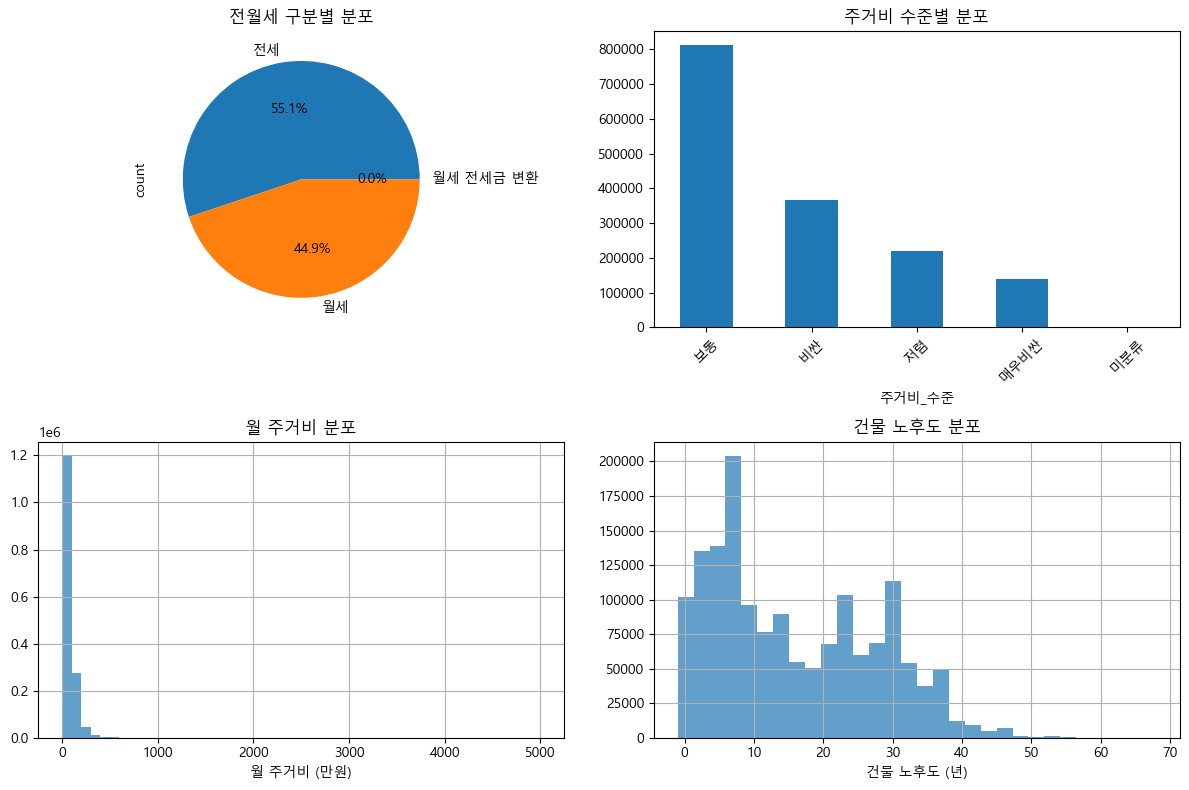

In [4]:
# 4-1. 전월세 구분별 분포
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
df['전월세구분'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('전월세 구분별 분포')

plt.subplot(2, 2, 2)
df['주거비_수준'].value_counts().plot(kind='bar')
plt.title('주거비 수준별 분포')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
df['월_주거비'].hist(bins=50, alpha=0.7)
plt.title('월 주거비 분포')
plt.xlabel('월 주거비 (만원)')

plt.subplot(2, 2, 4)
df['건물_노후도'].hist(bins=30, alpha=0.7)
plt.title('건물 노후도 분포')
plt.xlabel('건물 노후도 (년)')

plt.tight_layout()
plt.show()


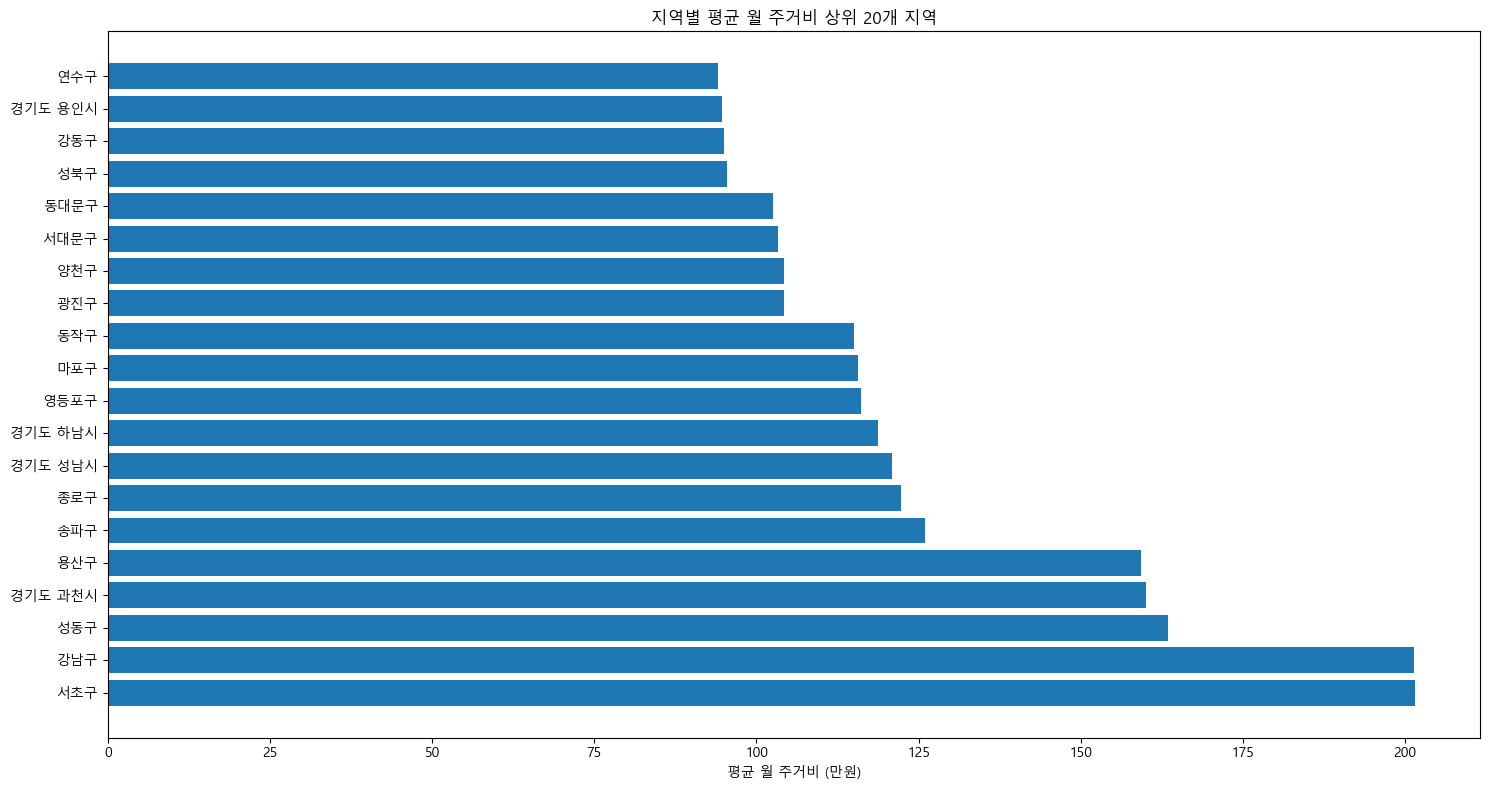

In [5]:
# 4-2. 지역별 주거비 상위 20개 지역
plt.figure(figsize=(15, 8))
top_regions = region_stats.nlargest(20, '월_주거비_mean')
plt.barh(range(len(top_regions)), top_regions['월_주거비_mean'])
plt.yticks(range(len(top_regions)), top_regions['전체_시군구'])
plt.title('지역별 평균 월 주거비 상위 20개 지역')
plt.xlabel('평균 월 주거비 (만원)')
plt.tight_layout()
plt.show()

In [6]:
# 5. 전처리된 데이터 저장
print("\n5. 전처리된 데이터 저장")
print("-" * 40)

# 메인 데이터프레임 저장
df.to_pickle("../data/housing_data_preprocessed.pkl")
print("전처리된 데이터 저장 완료: housing_data_preprocessed.pkl")


5. 전처리된 데이터 저장
----------------------------------------
전처리된 데이터 저장 완료: housing_data_preprocessed.pkl


In [8]:
# 지역별 통계 저장
region_stats.to_csv("../data/region_housing_stats.csv", index=False, encoding='utf-8')
print("지역별 통계 저장 완료: region_housing_stats.csv")

지역별 통계 저장 완료: region_housing_stats.csv


In [9]:
# 이상치 정보 저장
outlier_df = pd.DataFrame(outlier_summary).T
outlier_df.to_csv("../data/outlier_analysis.csv", encoding='utf-8')
print("이상치 분석 결과 저장 완료: outlier_analysis.csv")

이상치 분석 결과 저장 완료: outlier_analysis.csv


In [11]:
# 6. 요약 정보 출력
print("\n6. 전처리 요약 정보")
print("-" * 40)
print(f"총 데이터 개수: {len(df):,}개")
print(f"지역별 통계 생성: {len(region_stats)}개 지역")


6. 전처리 요약 정보
----------------------------------------
총 데이터 개수: 1,538,030개
지역별 통계 생성: 218개 지역


In [12]:
print("="*60)
print("주거실거래정보 데이터 전처리 및 파생 변수 생성")
print("="*60)

# 저장된 데이터 로딩
try:
    df = pd.read_pickle("../data/housing_data_cleaned.pkl")
    print(f"데이터 로딩 완료: {df.shape}")
except:
    print("이전 단계에서 저장된 데이터가 없습니다. 직접 로딩합니다.")
    df = pd.read_csv("../data/주거실거래정보.csv", encoding='utf-8')

주거실거래정보 데이터 전처리 및 파생 변수 생성
데이터 로딩 완료: (1538030, 22)


In [13]:
# 1. 데이터 전처리
print("\n1. 데이터 전처리 시작")
print("-" * 40)

# 1-1. 보증금, 월세금 컬럼 전처리 (문자열에서 숫자로 변환)
def clean_money_column(col):
    """보증금, 월세금 컬럼의 쉼표 제거 및 숫자 변환"""
    if col.dtype == 'object':
        # 쉼표 제거하고 NaN이 아닌 값들만 처리
        cleaned = col.astype(str).str.replace(',', '').str.replace(' ', '')
        # 숫자가 아닌 값들을 NaN으로 처리
        cleaned = pd.to_numeric(cleaned, errors='coerce')
        return cleaned
    return col

# 보증금, 월세금 컬럼 전처리
money_columns = ['보증금(만원)', '월세금(만원)', '종전계약 보증금(만원)', '종전계약 월세(만원)']
for col in money_columns:
    if col in df.columns:
        df[col] = clean_money_column(df[col])
        print(f"{col} 컬럼 전처리 완료")


1. 데이터 전처리 시작
----------------------------------------
보증금(만원) 컬럼 전처리 완료
월세금(만원) 컬럼 전처리 완료
종전계약 보증금(만원) 컬럼 전처리 완료
종전계약 월세(만원) 컬럼 전처리 완료


In [14]:
# 1-2. 계약년월 전처리 (YYYYMM -> datetime)
df['계약년월_str'] = df['계약년월'].astype(str)
df['계약년'] = df['계약년월_str'].str[:4].astype(int)
df['계약월'] = df['계약년월_str'].str[4:].astype(int)
df['계약일자'] = pd.to_datetime(df['계약년월_str'] + '01', format='%Y%m%d', errors='coerce')
print("계약년월 컬럼 전처리 완료")

계약년월 컬럼 전처리 완료


In [15]:
# 1-3. 시군구 정보 분리 및 정제
def extract_location_info(address):
    """주소에서 시도, 시군구, 읍면동 정보 추출"""
    if pd.isna(address):
        return pd.Series([None, None, None, None])
    
    # 기본 패턴 매칭
    pattern = r'(.*?)\s+(.*?)\s+(.*)'
    match = re.match(pattern, str(address))
    
    if match:
        sido = match.group(1).strip()
        sigungu = match.group(2).strip()
        eupmyeondong = match.group(3).strip()
        
        # 특별시/광역시 처리
        if '특별시' in sido or '광역시' in sido:
            full_sigungu = sigungu
        else:
            full_sigungu = f"{sido} {sigungu}"
            
        return pd.Series([sido, sigungu, eupmyeondong, full_sigungu])
    else:
        return pd.Series([address, None, None, address])

# 주소 정보 분리
location_info = df['시군구'].apply(extract_location_info)
df[['시도', '구_시군구', '읍면동', '전체_시군구']] = location_info
print("주소 정보 분리 완료")

주소 정보 분리 완료


# 탐색적 데이터 분석

In [17]:
print("="*60)
print("주거실거래정보 탐색적 데이터 분석 (EDA)")
print("="*60)

# 전처리된 데이터 로딩
try:
    df = pd.read_pickle("../data/housing_data_preprocessed.pkl")
    region_stats = pd.read_csv("../data/region_housing_stats.csv", encoding='utf-8-sig')
    print(f"전처리된 데이터 로딩 완료: {df.shape}")
    print(f"지역별 통계 데이터 로딩 완료: {region_stats.shape}")
except Exception as e:
    print(f"데이터 로딩 실패: {e}")
    exit()

주거실거래정보 탐색적 데이터 분석 (EDA)
전처리된 데이터 로딩 완료: (1538030, 34)
지역별 통계 데이터 로딩 완료: (218, 11)



1. 주거비 분포 및 특성 분석
--------------------------------------------------


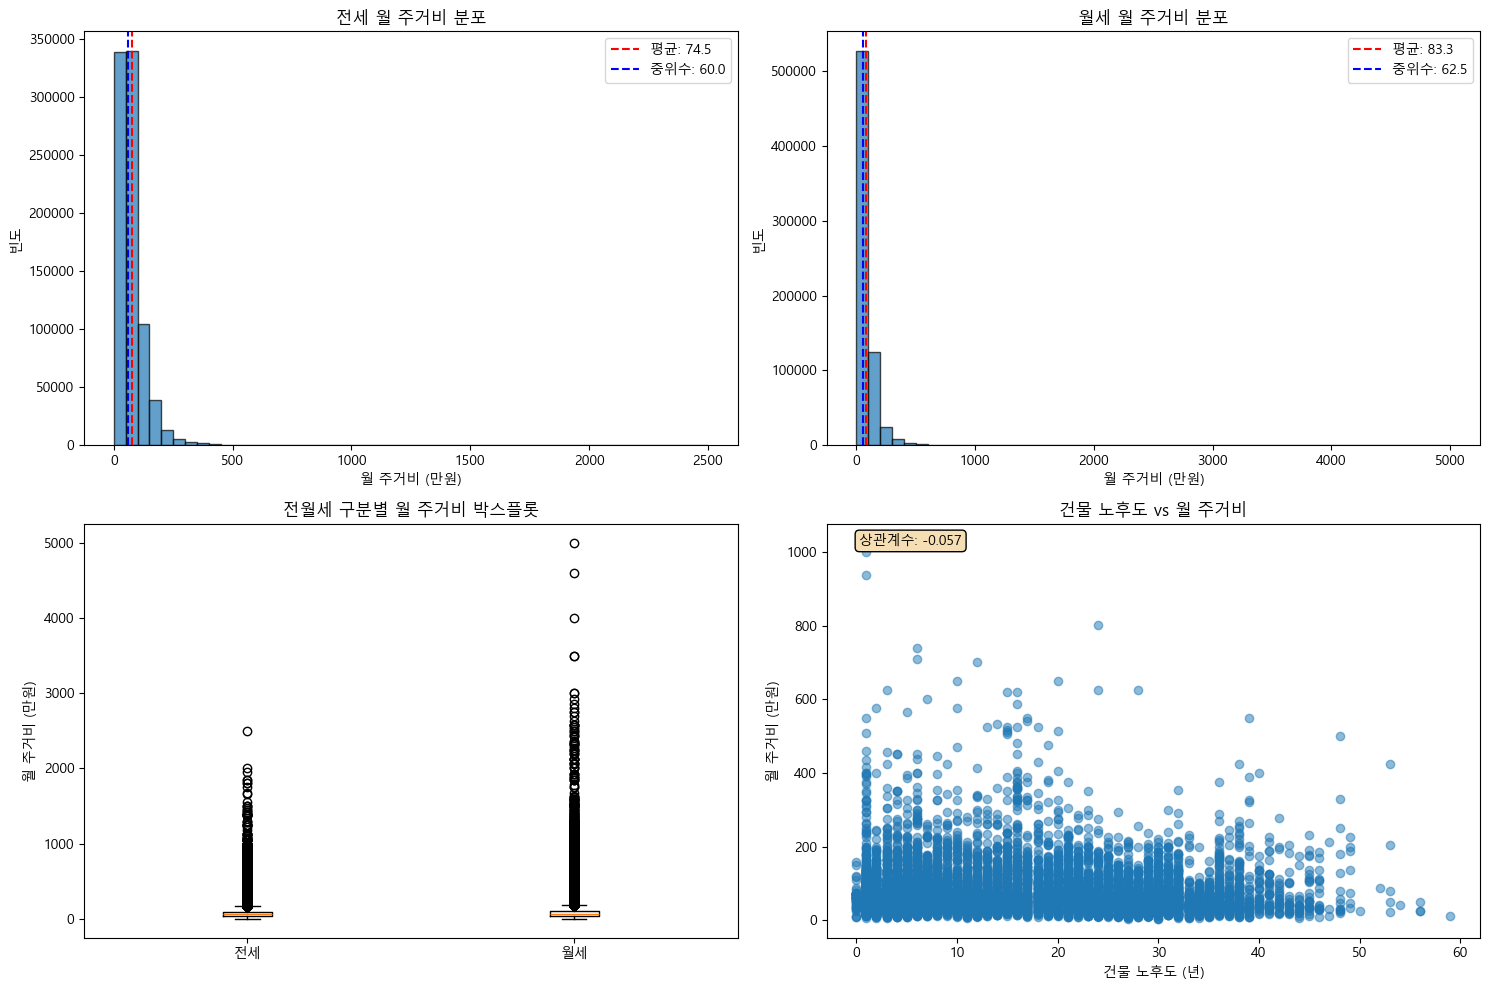

주거비 분석 차트 표시 완료


In [19]:
# 1. 주거비 분포 및 특성 분석
print("\n1. 주거비 분포 및 특성 분석")
print("-" * 50)

# 1-1. 전월세 구분별 주거비 분석
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 전월세 구분별 월 주거비 분포
df_clean = df.dropna(subset=['월_주거비'])
lease_types = df_clean['전월세구분'].unique()

for i, lease_type in enumerate(lease_types):
    if i < 2:
        data = df_clean[df_clean['전월세구분'] == lease_type]['월_주거비']
        axes[0, i].hist(data, bins=50, alpha=0.7, edgecolor='black')
        axes[0, i].set_title(f'{lease_type} 월 주거비 분포')
        axes[0, i].set_xlabel('월 주거비 (만원)')
        axes[0, i].set_ylabel('빈도')
        
        # 통계 정보 추가
        mean_val = data.mean()
        median_val = data.median()
        axes[0, i].axvline(mean_val, color='red', linestyle='--', label=f'평균: {mean_val:.1f}')
        axes[0, i].axvline(median_val, color='blue', linestyle='--', label=f'중위수: {median_val:.1f}')
        axes[0, i].legend()

# 전월세 구분별 박스플롯
axes[1, 0].boxplot([df_clean[df_clean['전월세구분'] == lt]['월_주거비'].dropna() 
                   for lt in lease_types], labels=lease_types)
axes[1, 0].set_title('전월세 구분별 월 주거비 박스플롯')
axes[1, 0].set_ylabel('월 주거비 (만원)')

# 건물 노후도별 주거비 관계
scatter_data = df_clean.sample(n=min(10000, len(df_clean)))  # 성능을 위해 샘플링
axes[1, 1].scatter(scatter_data['건물_노후도'], scatter_data['월_주거비'], alpha=0.5)
axes[1, 1].set_title('건물 노후도 vs 월 주거비')
axes[1, 1].set_xlabel('건물 노후도 (년)')
axes[1, 1].set_ylabel('월 주거비 (만원)')

# 상관관계 계산 및 표시
correlation = df_clean['건물_노후도'].corr(df_clean['월_주거비'])
axes[1, 1].text(0.05, 0.95, f'상관계수: {correlation:.3f}', 
                transform=axes[1, 1].transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))

plt.tight_layout()
plt.show()
print("주거비 분석 차트 표시 완료")

In [20]:
# 1-2. 주거비 수준별 상세 분석
housing_level_stats = df.groupby('주거비_수준').agg({
    '월_주거비': ['count', 'mean', 'median', 'std'],
    '전용면적(㎡)': ['mean', 'median'],
    '건물_노후도': ['mean', 'median'],
    '평당_가격': ['mean', 'median']
}).round(2)

print("\n주거비 수준별 통계:")
print(housing_level_stats)


주거비 수준별 통계:
         월_주거비                         전용면적(㎡)        건물_노후도        평당_가격  \
         count    mean  median     std    mean median   mean median  mean   
주거비_수준                                                                      
매우비싼    140726  234.27  197.50  119.21   94.28  84.96  15.35   14.0  8.67   
미분류          0     NaN     NaN     NaN   42.84  42.84  33.00   33.0   NaN   
보통      810669   53.75   52.50   13.89   59.81  59.89  15.73   12.0  3.56   
비싼      365958  107.88  105.00   19.62   77.07  84.47  14.97   13.0  5.12   
저렴      220676   20.94   21.25    6.13   43.00  40.92  18.03   17.0  1.85   

               
       median  
주거비_수준         
매우비싼     7.63  
미분류       NaN  
보통       2.91  
비싼       4.69  
저렴       1.66  


In [21]:
# 2. 지역별 주거비 패턴 분석
print("\n2. 지역별 주거비 패턴 분석")
print("-" * 50)

# 2-1. 시도별 주거비 분석
sido_stats = df.groupby('시도').agg({
    '월_주거비': ['count', 'mean', 'median', 'std'],
    '전용면적(㎡)': ['mean'],
    '건물_노후도': ['mean']
}).round(2)

sido_stats.columns = ['_'.join(col).strip() for col in sido_stats.columns]
sido_stats = sido_stats.reset_index()
sido_stats = sido_stats.sort_values('월_주거비_mean', ascending=False)

print("시도별 주거비 통계 (상위 10개):")
print(sido_stats.head(10))


2. 지역별 주거비 패턴 분석
--------------------------------------------------
시도별 주거비 통계 (상위 10개):
         시도  월_주거비_count  월_주거비_mean  월_주거비_median  월_주거비_std  전용면적(㎡)_mean  \
8     서울특별시       422434      116.79         87.50     102.46         59.75   
14  제주특별자치도        10756       77.16         59.25      64.02         62.76   
1       경기도       504429       74.42         64.50      47.87         65.95   
5     대구광역시        45947       65.43         57.50      37.36         74.47   
11    인천광역시        92391       63.98         57.50      38.49         66.87   
6     대전광역시        33531       61.96         57.50      33.67         69.67   
7     부산광역시        87999       59.66         50.00      39.25         62.90   
9   세종특별자치시        21561       57.51         55.00      27.26         66.12   
10    울산광역시        18234       57.29         52.50      29.76         70.40   
4     광주광역시        32081       53.59         48.30      30.20         66.44   

    건물_노후도_mean  
8         17.64  
14  

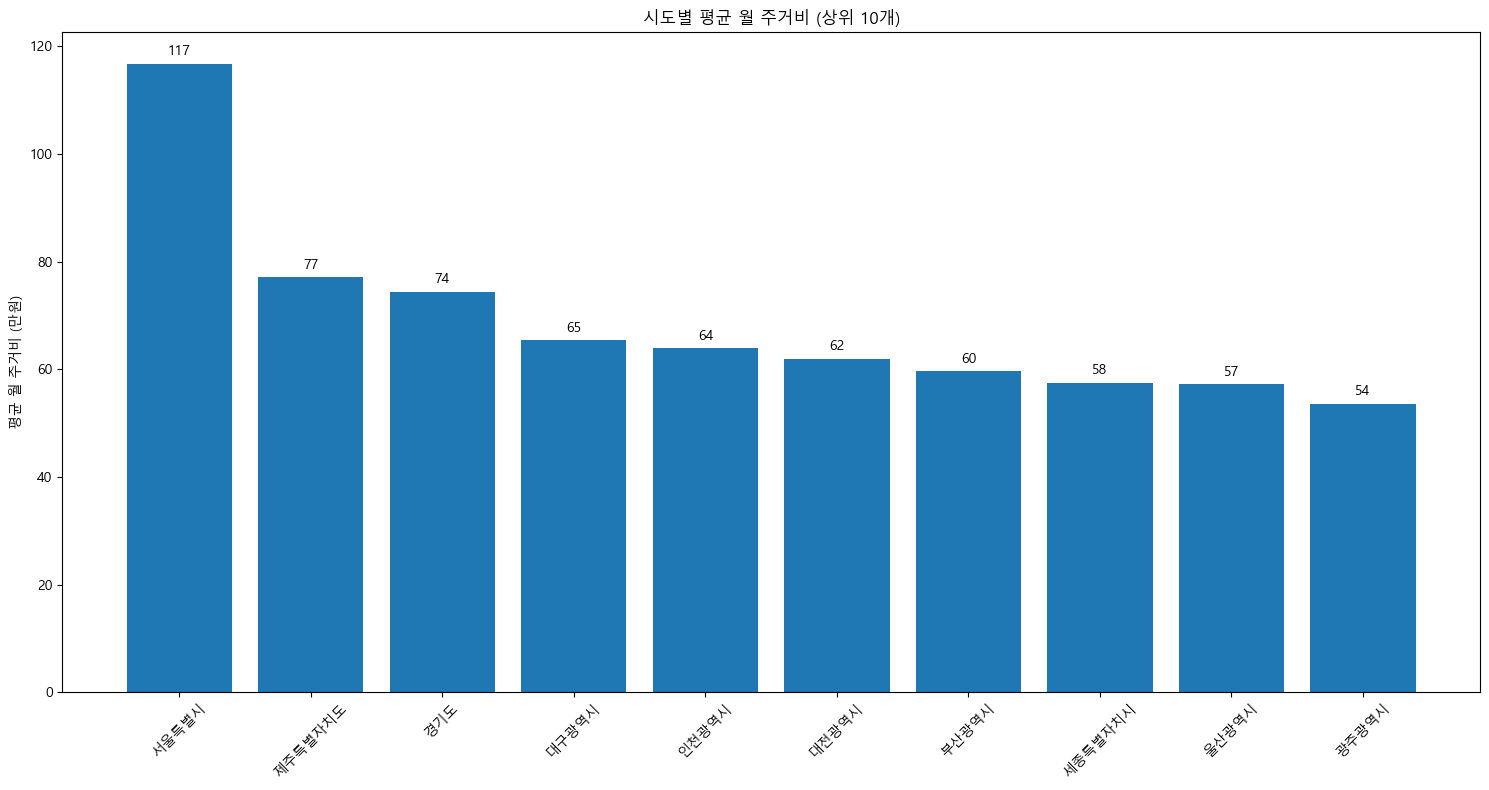

시도별 주거비 차트 표시 완료


In [22]:
# 2-2. 시도별 주거비 시각화
plt.figure(figsize=(15, 8))
top_sido = sido_stats.head(10)
bars = plt.bar(range(len(top_sido)), top_sido['월_주거비_mean'])
plt.xticks(range(len(top_sido)), top_sido['시도'], rotation=45)
plt.title('시도별 평균 월 주거비 (상위 10개)')
plt.ylabel('평균 월 주거비 (만원)')

# 막대 위에 값 표시
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
print("시도별 주거비 차트 표시 완료")

In [23]:
# 3. 주택유형별 분석
print("\n3. 주택유형별 분석")
print("-" * 50)

house_type_stats = df.groupby('주택유형').agg({
    '월_주거비': ['count', 'mean', 'median', 'std'],
    '전용면적(㎡)': ['mean', 'median'],
    '건물_노후도': ['mean', 'median'],
    '평당_가격': ['mean', 'median']
}).round(2)

house_type_stats.columns = ['_'.join(col).strip() for col in house_type_stats.columns]
house_type_stats = house_type_stats.reset_index()

print("주택유형별 통계:")
print(house_type_stats)


3. 주택유형별 분석
--------------------------------------------------
주택유형별 통계:
    주택유형  월_주거비_count  월_주거비_mean  월_주거비_median  월_주거비_std  전용면적(㎡)_mean  \
0    아파트      1276468       83.17         65.00      72.48         69.11   
1  연립다세대       261561       55.37         49.88      38.59         42.93   

   전용면적(㎡)_median  건물_노후도_mean  건물_노후도_median  평당_가격_mean  평당_가격_median  
0           63.40        15.76           13.0        3.97          3.21  
1           39.83        16.29           12.0        5.03          4.24  


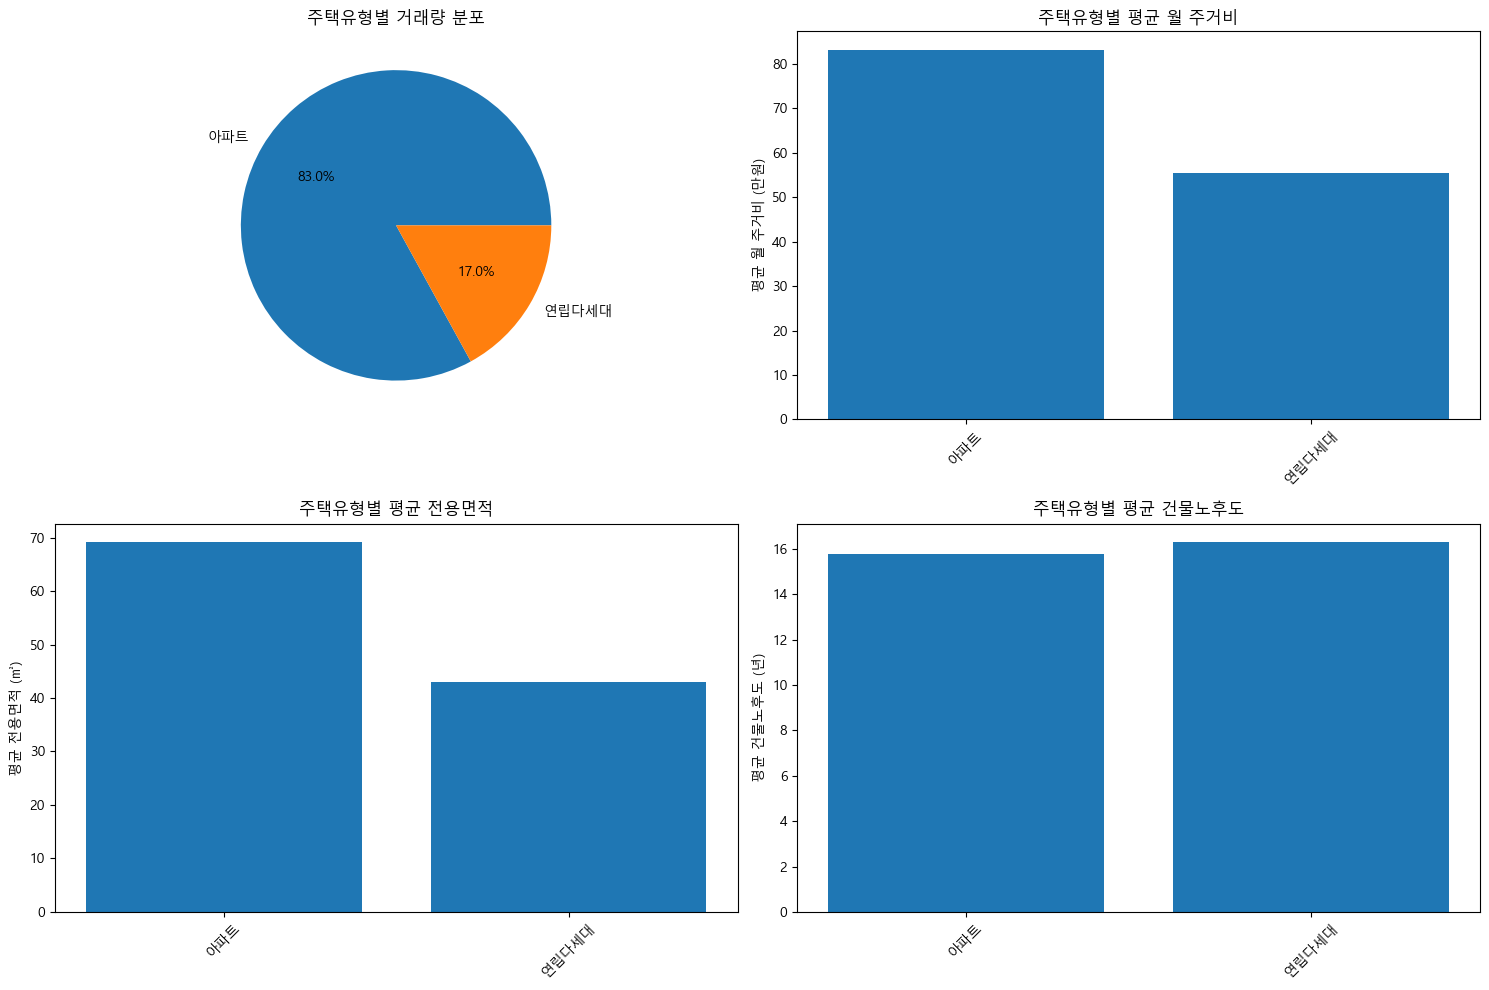

주택유형별 분석 차트 표시 완료


In [24]:
# 주택유형별 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 주택유형별 거래량
house_type_counts = df['주택유형'].value_counts()
axes[0, 0].pie(house_type_counts.values, labels=house_type_counts.index, autopct='%1.1f%%')
axes[0, 0].set_title('주택유형별 거래량 분포')

# 주택유형별 평균 주거비
axes[0, 1].bar(house_type_stats['주택유형'], house_type_stats['월_주거비_mean'])
axes[0, 1].set_title('주택유형별 평균 월 주거비')
axes[0, 1].set_ylabel('평균 월 주거비 (만원)')
axes[0, 1].tick_params(axis='x', rotation=45)

# 주택유형별 평균 면적
axes[1, 0].bar(house_type_stats['주택유형'], house_type_stats['전용면적(㎡)_mean'])
axes[1, 0].set_title('주택유형별 평균 전용면적')
axes[1, 0].set_ylabel('평균 전용면적 (㎡)')
axes[1, 0].tick_params(axis='x', rotation=45)

# 주택유형별 평균 건물노후도
axes[1, 1].bar(house_type_stats['주택유형'], house_type_stats['건물_노후도_mean'])
axes[1, 1].set_title('주택유형별 평균 건물노후도')
axes[1, 1].set_ylabel('평균 건물노후도 (년)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
print("주택유형별 분석 차트 표시 완료")


4. 시계열 분석
--------------------------------------------------


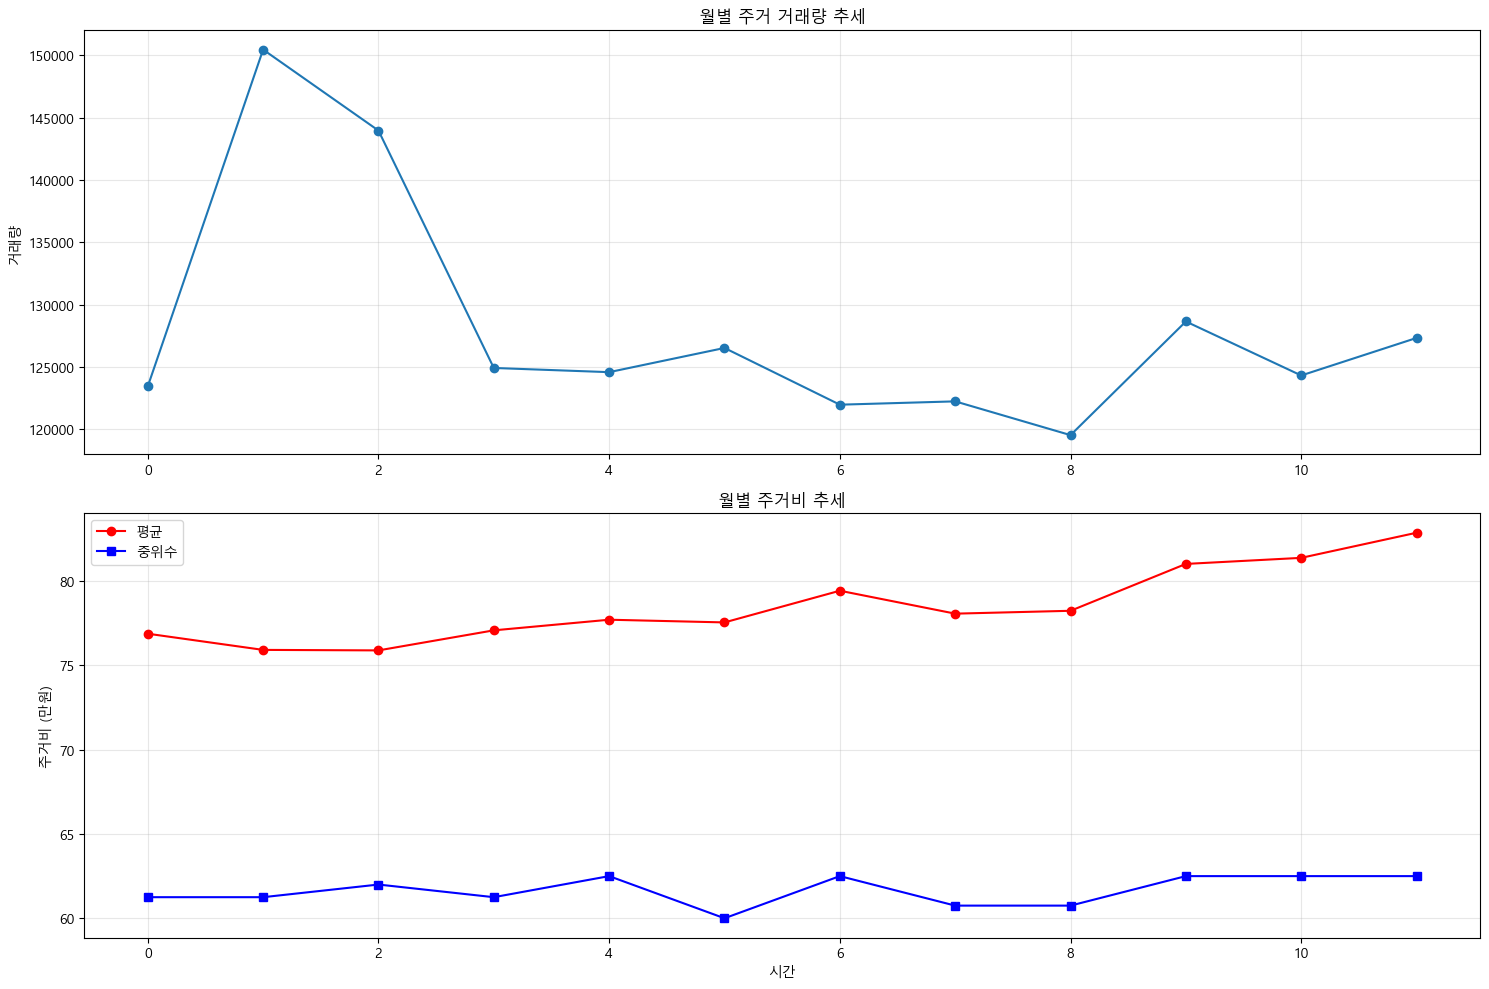

시계열 분석 차트 표시 완료


In [25]:
# 4. 시계열 분석
print("\n4. 시계열 분석")
print("-" * 50)

# 4-1. 월별 거래량 및 주거비 추세
monthly_stats = df.groupby(['계약년', '계약월']).agg({
    'NO': 'count',
    '월_주거비': ['mean', 'median']
}).round(2)

monthly_stats.columns = ['거래량', '평균_주거비', '중위수_주거비']
monthly_stats = monthly_stats.reset_index()
monthly_stats['년월'] = monthly_stats['계약년'].astype(str) + '-' + monthly_stats['계약월'].astype(str).str.zfill(2)

# 시계열 시각화
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 월별 거래량 추세
axes[0].plot(monthly_stats.index, monthly_stats['거래량'], marker='o')
axes[0].set_title('월별 주거 거래량 추세')
axes[0].set_ylabel('거래량')
axes[0].grid(True, alpha=0.3)

# 월별 평균 주거비 추세
axes[1].plot(monthly_stats.index, monthly_stats['평균_주거비'], marker='o', color='red', label='평균')
axes[1].plot(monthly_stats.index, monthly_stats['중위수_주거비'], marker='s', color='blue', label='중위수')
axes[1].set_title('월별 주거비 추세')
axes[1].set_ylabel('주거비 (만원)')
axes[1].set_xlabel('시간')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("시계열 분석 차트 표시 완료")



5. 상관관계 분석
--------------------------------------------------


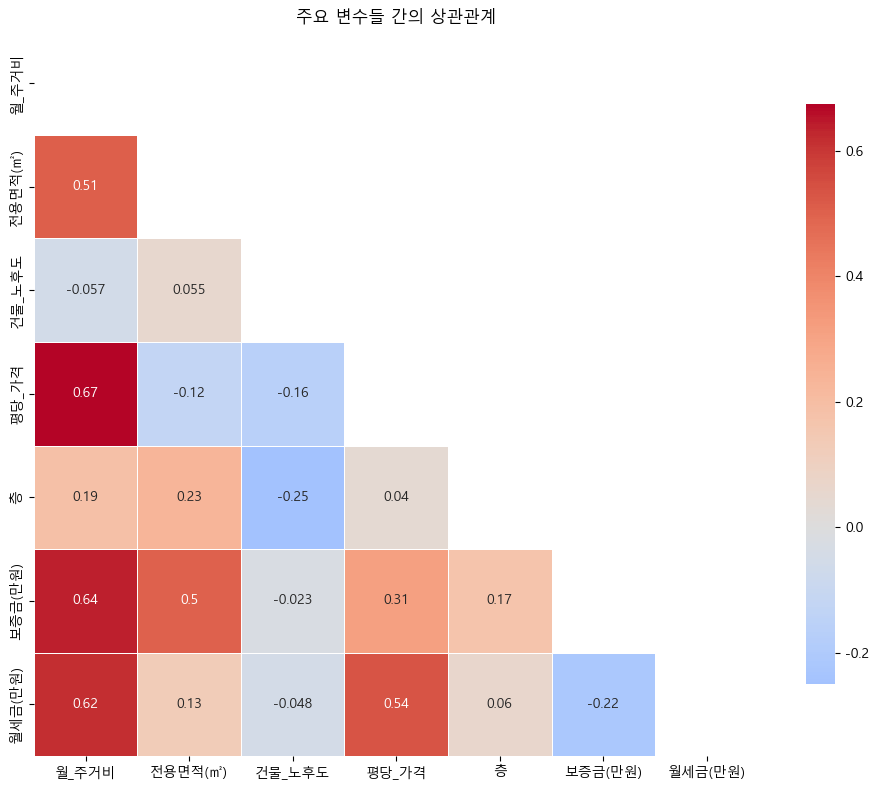

상관관계 분석 차트 표시 완료


In [26]:
# 5. 상관관계 분석
print("\n5. 상관관계 분석")
print("-" * 50)

# 수치형 변수들 간의 상관관계 분석
numeric_columns = ['월_주거비', '전용면적(㎡)', '건물_노후도', '평당_가격', '층', '보증금(만원)', '월세금(만원)']
correlation_data = df[numeric_columns].corr()

# 상관관계 히트맵
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_data, dtype=bool))
sns.heatmap(correlation_data, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('주요 변수들 간의 상관관계')
plt.tight_layout()
plt.show()
print("상관관계 분석 차트 표시 완료")

In [27]:
print("\n상관관계 분석 결과:")
print("월_주거비와 다른 변수들 간의 상관관계:")
housing_correlations = correlation_data['월_주거비'].drop('월_주거비').sort_values(key=abs, ascending=False)
for var, corr in housing_correlations.items():
    print(f"  {var}: {corr:.3f}")


상관관계 분석 결과:
월_주거비와 다른 변수들 간의 상관관계:
  평당_가격: 0.675
  보증금(만원): 0.636
  월세금(만원): 0.616
  전용면적(㎡): 0.505
  층: 0.185
  건물_노후도: -0.057



6. 이상치 분석
--------------------------------------------------


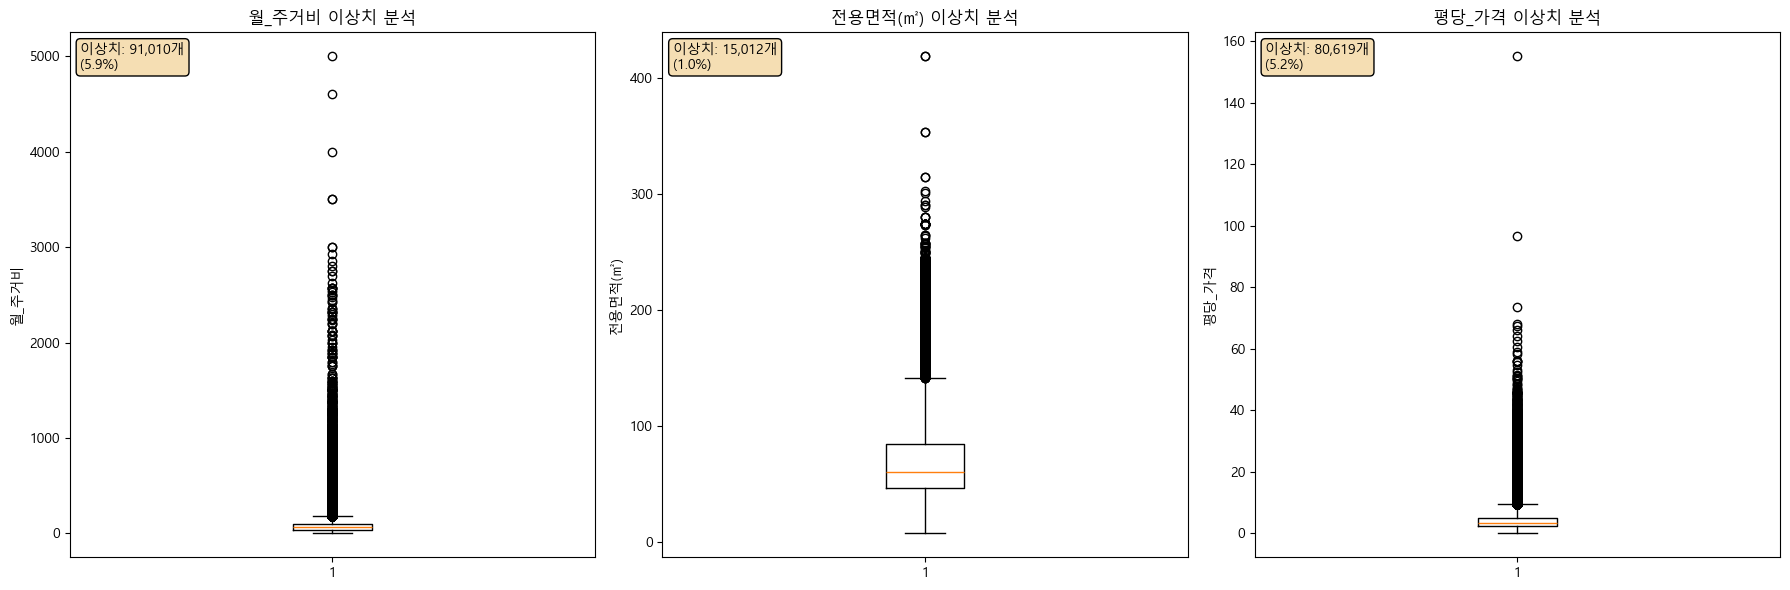

이상치 분석 차트 표시 완료


In [28]:
# 6. 이상치 분석
print("\n6. 이상치 분석")
print("-" * 50)

# 주요 변수들의 이상치 시각화
outlier_columns = ['월_주거비', '전용면적(㎡)', '평당_가격']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(outlier_columns):
    # 박스플롯으로 이상치 표시
    axes[i].boxplot(df[col].dropna())
    axes[i].set_title(f'{col} 이상치 분석')
    axes[i].set_ylabel(col)
    
    # 통계 정보 추가
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    axes[i].text(0.02, 0.98, f'이상치: {len(outliers):,}개\n({len(outliers)/len(df)*100:.1f}%)',
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle="round", facecolor='wheat'))

plt.tight_layout()
plt.show()
print("이상치 분석 차트 표시 완료")

In [29]:
print("\n7. 종합 인사이트 도출")
print("-" * 50)

insights = {
    "데이터 규모": f"총 {len(df):,}건의 주거 거래 데이터 분석",
    "주요 거래 유형": df['전월세구분'].value_counts().to_dict(),
    "평균 주거비": f"{df['월_주거비'].mean():.1f}만원",
    "주거비 중위수": f"{df['월_주거비'].median():.1f}만원",
    "가장 비싼 지역": region_stats.nlargest(1, '월_주거비_mean')['전체_시군구'].iloc[0],
    "가장 저렴한 지역": region_stats.nsmallest(1, '월_주거비_mean')['전체_시군구'].iloc[0],
    "주택유형별 거래량": df['주택유형'].value_counts().to_dict(),
    "건물 평균 노후도": f"{df['건물_노후도'].mean():.1f}년"
}

print("주요 인사이트:")
for key, value in insights.items():
    print(f"  {key}: {value}")


7. 종합 인사이트 도출
--------------------------------------------------
주요 인사이트:
  데이터 규모: 총 1,538,030건의 주거 거래 데이터 분석
  주요 거래 유형: {'전세': 848053, '월세': 689976, '월세 전세금 변환': 1}
  평균 주거비: 78.4만원
  주거비 중위수: 62.5만원
  가장 비싼 지역: 서초구
  가장 저렴한 지역: 세종특별자치시 장군면
  주택유형별 거래량: {'아파트': 1276469, '연립다세대': 261561}
  건물 평균 노후도: 15.8년


In [30]:
# 8. 분석 결과 요약 저장
print("\n8. 분석 결과 요약 저장")
print("-" * 50)

# EDA 요약 정보를 JSON으로 저장
import json
eda_summary = {
    "분석_일시": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
    "데이터_규모": len(df),
    "생성된_차트": 6,
    "주요_인사이트": insights,
    "시도별_상위5": sido_stats.head(5)[['시도', '월_주거비_mean']].to_dict('records'),
    "주택유형별_통계": house_type_stats[['주택유형', '월_주거비_mean', '월_주거비_count']].to_dict('records')
}

with open('../data/eda_summary.json', 'w', encoding='utf-8') as f:
    json.dump(eda_summary, f, ensure_ascii=False, indent=2)


8. 분석 결과 요약 저장
--------------------------------------------------


# 생활비 기반 지역 클러스터링 분석

In [33]:
print("="*60)
print("생활비 기반 지역 클러스터링 분석")
print("="*60)

# 데이터 로딩
try:
    df = pd.read_pickle("../data/housing_data_preprocessed.pkl")
    region_stats = pd.read_csv("../data/region_housing_stats.csv", encoding='utf-8-sig')
    print(f"데이터 로딩 완료: {df.shape}")
    print(f"지역별 통계 데이터 로딩 완료: {region_stats.shape}")
except Exception as e:
    print(f"데이터 로딩 실패: {e}")
    exit()

# 1. 클러스터링을 위한 지역별 특성 변수 생성
print("\n1. 클러스터링을 위한 지역별 특성 변수 생성")
print("-" * 50)

# 1-1. 기본 지역별 통계 (이미 생성된 region_stats 활용)
clustering_features = region_stats.copy()

# 1-2. 추가 특성 변수 생성
# 전월세 비율
lease_ratio = df.groupby('전체_시군구')['전월세구분'].apply(
    lambda x: (x == '전세').sum() / len(x) * 100
).round(2).reset_index()
lease_ratio.columns = ['전체_시군구', '전세_비율']

# 주택유형 분포
house_type_dist = df.groupby('전체_시군구')['주택유형'].apply(
    lambda x: (x == '아파트').sum() / len(x) * 100
).round(2).reset_index()
house_type_dist.columns = ['전체_시군구', '아파트_비율']

# 주거비 수준 분포
housing_level_dist = df.groupby('전체_시군구')['주거비_수준'].apply(
    lambda x: pd.Series({
        '저렴_비율': (x == '저렴').sum() / len(x) * 100,
        '보통_비율': (x == '보통').sum() / len(x) * 100,
        '비싼_비율': (x == '비싼').sum() / len(x) * 100,
        '매우비싼_비율': (x == '매우비싼').sum() / len(x) * 100
    })
).round(2).reset_index()

# 시계열 특성 (최근 1년 거래량 변화)
recent_data = df[df['계약년'] >= 2023]
recent_volume = recent_data.groupby('전체_시군구').size().reset_index()
recent_volume.columns = ['전체_시군구', '최근거래량']
total_volume = df.groupby('전체_시군구').size().reset_index()
total_volume.columns = ['전체_시군구', '총거래량']

# 최근 거래 비율 계산
recent_ratio = recent_volume.merge(total_volume, on='전체_시군구', how='right')
recent_ratio['최근거래_비율'] = (recent_ratio['최근거래량'] / recent_ratio['총거래량'] * 100).fillna(0).round(2)
recent_ratio = recent_ratio[['전체_시군구', '최근거래_비율']]

# 모든 특성을 하나의 DataFrame으로 결합
clustering_features = clustering_features.merge(lease_ratio, on='전체_시군구', how='left')
clustering_features = clustering_features.merge(house_type_dist, on='전체_시군구', how='left')
clustering_features = clustering_features.merge(housing_level_dist, on='전체_시군구', how='left')
clustering_features = clustering_features.merge(recent_ratio, on='전체_시군구', how='left')

# 결측치 처리
clustering_features = clustering_features.fillna(0)

print(f"클러스터링 특성 변수 생성 완료: {clustering_features.shape}")
print("생성된 특성 변수:")
for col in clustering_features.columns:
    print(f"  - {col}")

생활비 기반 지역 클러스터링 분석
데이터 로딩 완료: (1538030, 34)
지역별 통계 데이터 로딩 완료: (218, 11)

1. 클러스터링을 위한 지역별 특성 변수 생성
--------------------------------------------------
클러스터링 특성 변수 생성 완료: (872, 16)
생성된 특성 변수:
  - 전체_시군구
  - 월_주거비_mean
  - 월_주거비_median
  - 월_주거비_std
  - 월_주거비_count
  - 전용면적(㎡)_mean
  - 전용면적(㎡)_median
  - 건물_노후도_mean
  - 건물_노후도_median
  - 평당_가격_mean
  - 평당_가격_median
  - 전세_비율
  - 아파트_비율
  - level_1
  - 주거비_수준
  - 최근거래_비율


In [35]:
# 2. 클러스터링 분석을 위한 데이터 전처리
print("\n2. 클러스터링 분석을 위한 데이터 전처리")
print("-" * 50)

# 2-1. 클러스터링에 사용할 핵심 변수 선택
feature_columns = [
    '월_주거비_mean', '월_주거비_median', '월_주거비_std',
    '전용면적(㎡)_mean', '전용면적(㎡)_median',
    '건물_노후도_mean', '건물_노후도_median',
    '평당_가격_mean', '평당_가격_median',
    '전세_비율', '아파트_비율', '최근거래_비율'
]

# 거래량이 너무 적은 지역 제외 (최소 100건 이상)
min_transactions = 100
valid_regions = clustering_features[clustering_features['월_주거비_count'] >= min_transactions]

print(f"최소 거래량 {min_transactions}건 이상 지역: {len(valid_regions)}개")

# 클러스터링 데이터 준비
cluster_data = valid_regions[feature_columns].copy()
region_names = valid_regions['전체_시군구'].values

# 2-2. 데이터 정규화
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)
cluster_data_scaled_df = pd.DataFrame(cluster_data_scaled, columns=feature_columns, index=region_names)

print("데이터 정규화 완료")


2. 클러스터링 분석을 위한 데이터 전처리
--------------------------------------------------
최소 거래량 100건 이상 지역: 684개
데이터 정규화 완료



3. 최적 클러스터 수 결정
--------------------------------------------------


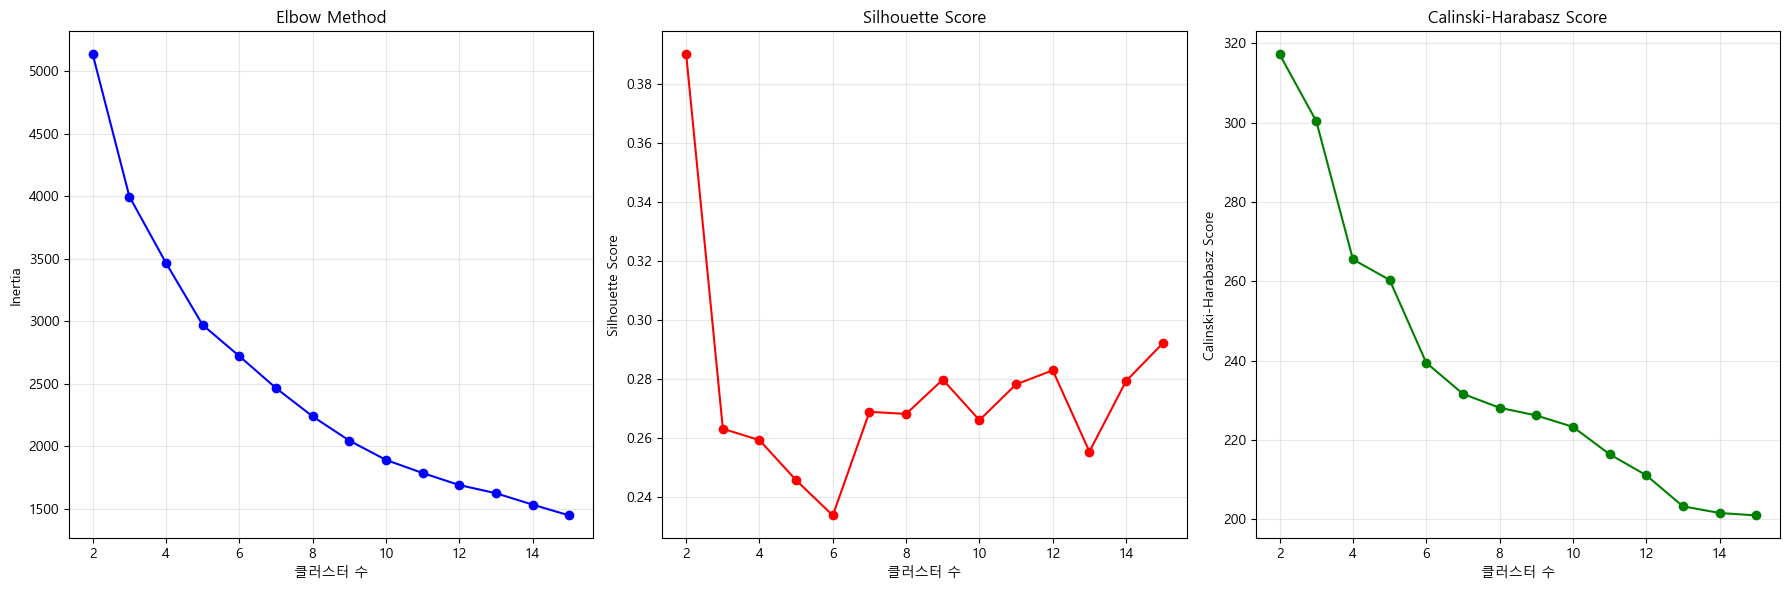

최적 클러스터 수 (Silhouette Score 기준): 2
최적 Silhouette Score: 0.390


In [39]:
# 3. 최적 클러스터 수 결정
print("\n3. 최적 클러스터 수 결정")
print("-" * 50)

# 3-1. Elbow Method와 Silhouette Score
max_clusters = min(15, len(cluster_data_scaled) // 2)
inertias = []
silhouette_scores = []
calinski_scores = []

# KMeans에서 n_jobs 파라미터 제거 (scikit-learn 버전에 따라 지원하지 않을 수 있음)
for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(cluster_data_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(cluster_data_scaled, cluster_labels))
    calinski_scores.append(calinski_harabasz_score(cluster_data_scaled, cluster_labels))

# 최적 클러스터 수 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Elbow Method
axes[0].plot(range(2, max_clusters + 1), inertias, 'bo-')
axes[0].set_title('Elbow Method')
axes[0].set_xlabel('클러스터 수')
axes[0].set_ylabel('Inertia')
axes[0].grid(True, alpha=0.3)

# Silhouette Score
axes[1].plot(range(2, max_clusters + 1), silhouette_scores, 'ro-')
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('클러스터 수')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True, alpha=0.3)

# Calinski-Harabasz Score
axes[2].plot(range(2, max_clusters + 1), calinski_scores, 'go-')
axes[2].set_title('Calinski-Harabasz Score')
axes[2].set_xlabel('클러스터 수')
axes[2].set_ylabel('Calinski-Harabasz Score')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 최적 클러스터 수 결정 (Silhouette Score 기준)
optimal_k = range(2, max_clusters + 1)[np.argmax(silhouette_scores)]
print(f"최적 클러스터 수 (Silhouette Score 기준): {optimal_k}")
print(f"최적 Silhouette Score: {max(silhouette_scores):.3f}")

In [40]:
# 4. K-Means 클러스터링 수행
print("\n4. K-Means 클러스터링 수행")
print("-" * 50)

# 4-1. 최적 클러스터 수로 K-Means 실행
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_optimal.fit_predict(cluster_data_scaled)

# 클러스터 결과를 원본 데이터에 추가
valid_regions_clustered = valid_regions.copy()
valid_regions_clustered['클러스터'] = cluster_labels

print(f"클러스터링 완료: {optimal_k}개 클러스터")
print("클러스터별 지역 수:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"  클러스터 {cluster_id}: {count}개 지역")


4. K-Means 클러스터링 수행
--------------------------------------------------
클러스터링 완료: 2개 클러스터
클러스터별 지역 수:
  클러스터 0: 544개 지역
  클러스터 1: 140개 지역


In [41]:
# 5. 클러스터 특성 분석
print("\n5. 클러스터 특성 분석")
print("-" * 50)

# 5-1. 클러스터별 특성 요약
cluster_summary = valid_regions_clustered.groupby('클러스터')[feature_columns].mean().round(2)
print("클러스터별 평균 특성:")
print(cluster_summary)

# 5-2. 클러스터별 대표 지역
print("\n클러스터별 대표 지역 (각 클러스터별 상위 5개 지역):")
for cluster_id in range(optimal_k):
    cluster_regions = valid_regions_clustered[valid_regions_clustered['클러스터'] == cluster_id]
    top_regions = cluster_regions.nlargest(5, '월_주거비_count')['전체_시군구'].tolist()
    print(f"  클러스터 {cluster_id}: {', '.join(top_regions)}")


5. 클러스터 특성 분석
--------------------------------------------------
클러스터별 평균 특성:
      월_주거비_mean  월_주거비_median  월_주거비_std  전용면적(㎡)_mean  전용면적(㎡)_median  \
클러스터                                                                      
0          47.49         43.86      25.41         64.53           64.19   
1         104.32         89.15      68.06         61.65           59.46   

      건물_노후도_mean  건물_노후도_median  평당_가격_mean  평당_가격_median  전세_비율  아파트_비율  \
클러스터                                                                        
0           14.52          12.82        2.49          2.27  51.33   88.71   
1           17.70          16.86        5.77          5.28  58.30   70.93   

      최근거래_비율  
클러스터           
0       100.0  
1       100.0  

클러스터별 대표 지역 (각 클러스터별 상위 5개 지역):
  클러스터 0: 경기도 화성시, 경기도 화성시, 경기도 화성시, 경기도 화성시, 경기도 수원시
  클러스터 1: 송파구, 송파구, 송파구, 송파구, 경기도 용인시



6. 클러스터링 결과 시각화
--------------------------------------------------


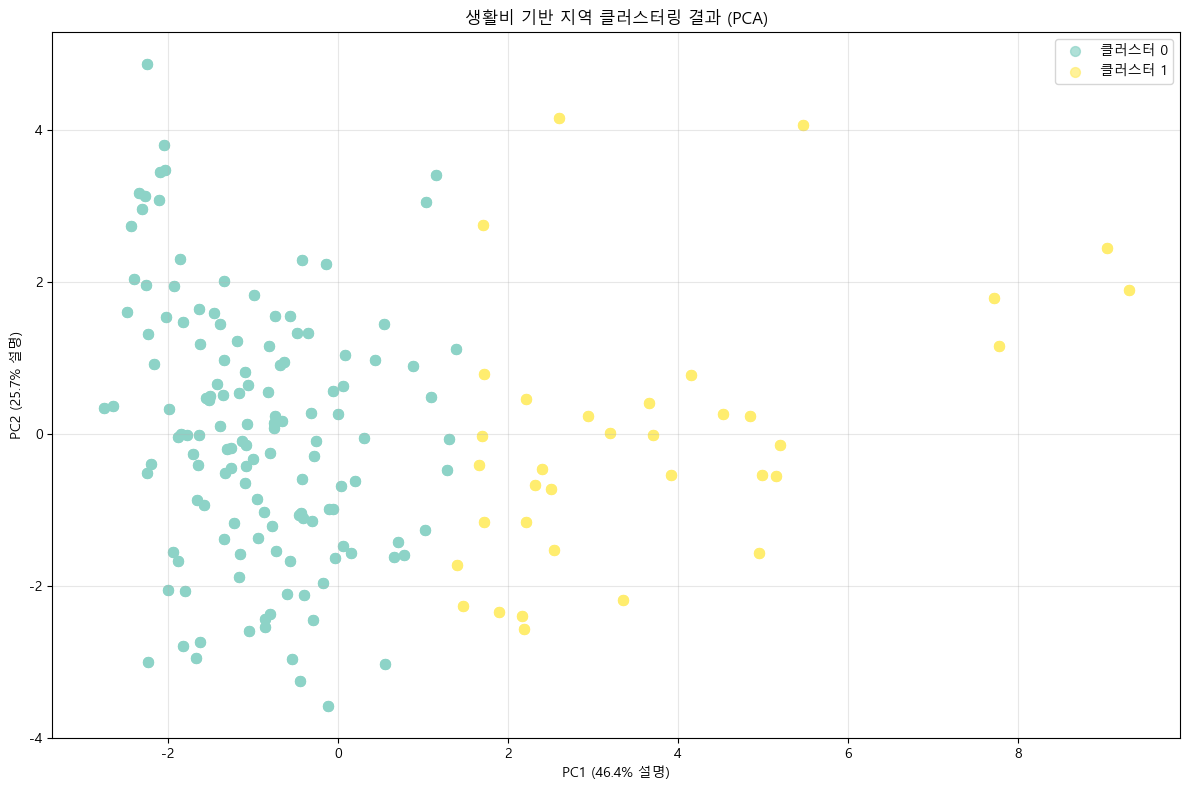

In [42]:
# 6. 클러스터링 결과 시각화
print("\n6. 클러스터링 결과 시각화")
print("-" * 50)

# 6-1. PCA를 이용한 2D 시각화
pca = PCA(n_components=2)
cluster_data_pca = pca.fit_transform(cluster_data_scaled)

plt.figure(figsize=(12, 8))
colors = plt.cm.Set3(np.linspace(0, 1, optimal_k))

for i in range(optimal_k):
    cluster_mask = cluster_labels == i
    plt.scatter(cluster_data_pca[cluster_mask, 0], cluster_data_pca[cluster_mask, 1], 
               c=[colors[i]], label=f'클러스터 {i}', alpha=0.7, s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} 설명)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} 설명)')
plt.title('생활비 기반 지역 클러스터링 결과 (PCA)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

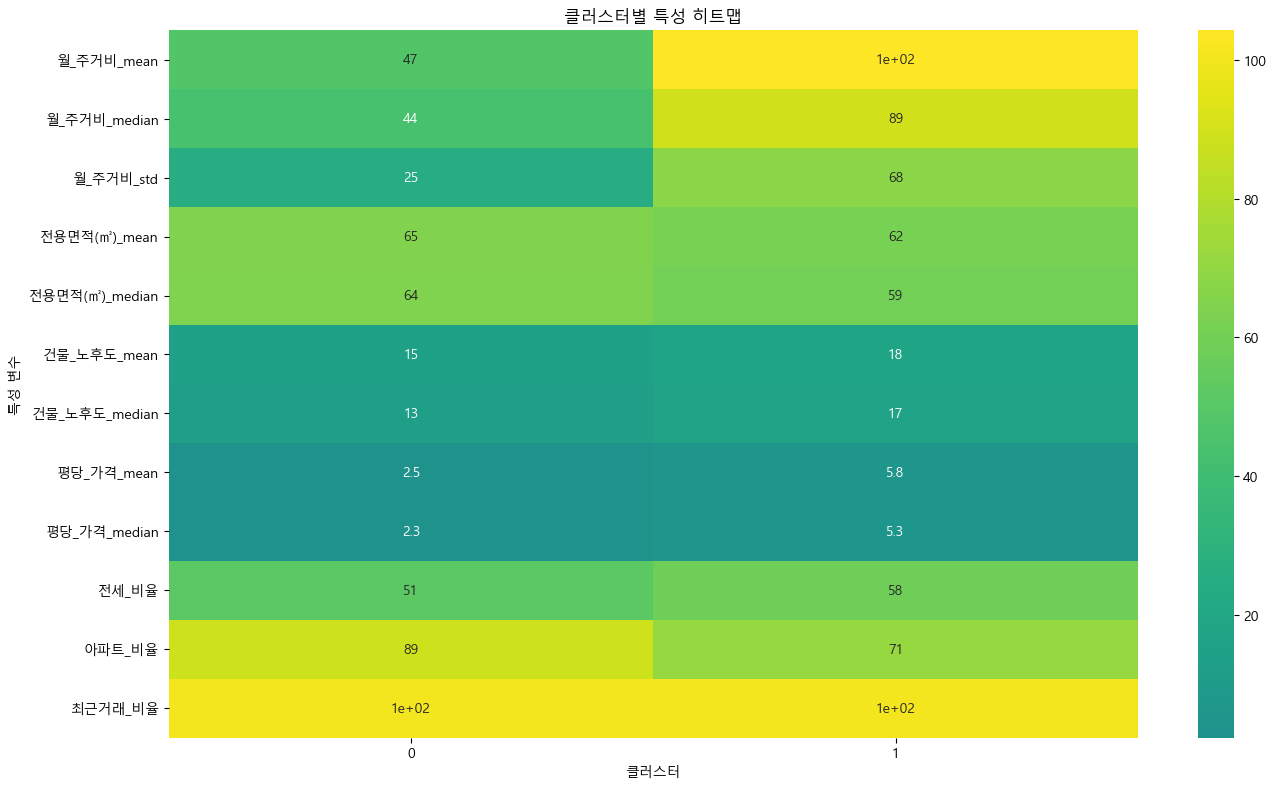

In [43]:
# 6-2. 클러스터별 특성 히트맵
plt.figure(figsize=(14, 8))
sns.heatmap(cluster_summary.T, annot=True, cmap='viridis', center=0)
plt.title('클러스터별 특성 히트맵')
plt.xlabel('클러스터')
plt.ylabel('특성 변수')
plt.tight_layout()
plt.show()

사용 가능한 컬럼: ['전체_시군구', '월_주거비_mean', '월_주거비_median', '월_주거비_std', '월_주거비_count', '전용면적(㎡)_mean', '전용면적(㎡)_median', '건물_노후도_mean', '건물_노후도_median', '평당_가격_mean', '평당_가격_median', '전세_비율', '아파트_비율', 'level_1', '주거비_수준', '최근거래_비율', '클러스터']
실제 사용할 특성: ['월_주거비_mean', '전용면적(㎡)_mean', '건물_노후도_mean', '전세_비율', '아파트_비율', '최근거래_비율']


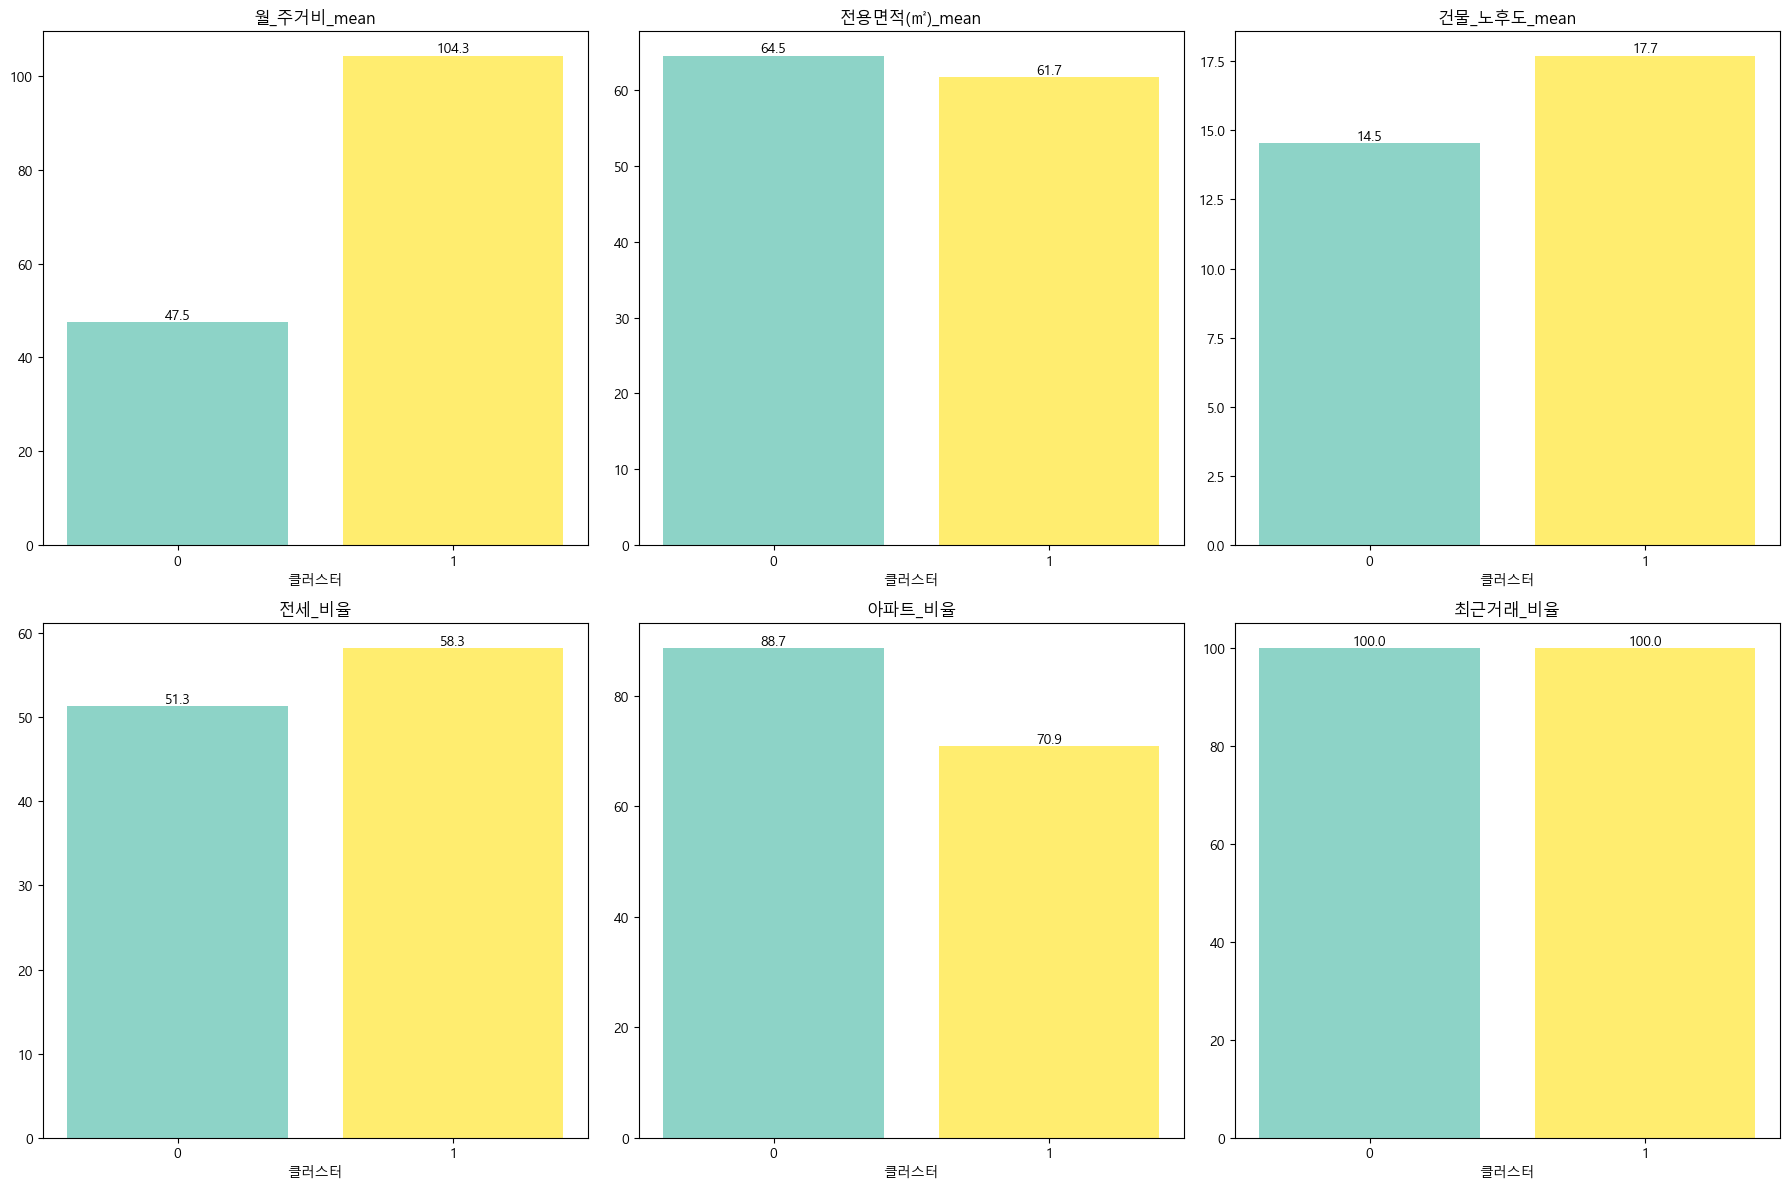

In [45]:
# 6-3. 주요 특성별 클러스터 비교
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 실제 존재하는 컬럼명으로 수정
available_columns = valid_regions_clustered.columns.tolist()
print(f"사용 가능한 컬럼: {available_columns}")

# 존재하는 컬럼만 선택
key_features = ['월_주거비_mean', '전용면적(㎡)_mean', '건물_노후도_mean', 
               '전세_비율', '아파트_비율', '최근거래_비율']

# 실제 존재하는 특성만 필터링
existing_features = [feature for feature in key_features if feature in available_columns]
print(f"실제 사용할 특성: {existing_features}")

# 6개 미만인 경우 다른 특성으로 보완
if len(existing_features) < 6:
    additional_features = ['월_주거비_median', '평당_가격_mean', '건물_노후도_median']
    for feature in additional_features:
        if feature in available_columns and feature not in existing_features:
            existing_features.append(feature)
            if len(existing_features) >= 6:
                break

# 최종 6개 특성 선택
final_features = existing_features[:6]

for i, feature in enumerate(final_features):
    row, col = i // 3, i % 3
    
    cluster_means = [valid_regions_clustered[valid_regions_clustered['클러스터'] == k][feature].mean() 
                    for k in range(optimal_k)]
    
    bars = axes[row, col].bar(range(optimal_k), cluster_means, color=colors)
    axes[row, col].set_title(f'{feature}')
    axes[row, col].set_xlabel('클러스터')
    axes[row, col].set_xticks(range(optimal_k))
    
    # 막대 위에 값 표시
    for bar, value in zip(bars, cluster_means):
        axes[row, col].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                           f'{value:.1f}', ha='center', va='bottom')

# 사용하지 않는 subplot 숨기기
for i in range(len(final_features), 6):
    row, col = i // 3, i % 3
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

In [49]:
# 7. 클러스터 해석 및 명명
print("\n7. 클러스터 해석 및 명명")
print("-" * 50)

# 클러스터별 특성을 기반으로 의미있는 이름 부여
cluster_names = {}
cluster_descriptions = {}

for cluster_id in range(optimal_k):
    cluster_data = valid_regions_clustered[valid_regions_clustered['클러스터'] == cluster_id]
    
    avg_cost = cluster_data['월_주거비_mean'].mean()
    avg_area = cluster_data['전용면적(㎡)_mean'].mean()
    avg_age = cluster_data['건물_노후도_mean'].mean()
    apt_ratio = cluster_data['아파트_비율'].mean()
    
    # 존재하는 컬럼만 사용하여 고비용 비율 계산
    expensive_ratio = 0
    if '비싼_비율' in cluster_data.columns:
        expensive_ratio += cluster_data['비싼_비율'].mean()
    if '매우비싼_비율' in cluster_data.columns:
        expensive_ratio += cluster_data['매우비싼_비율'].mean()
    
    # 클러스터 명명 로직
    if avg_cost >= 100:
        cost_level = "고비용"
    elif avg_cost >= 60:
        cost_level = "중비용"
    else:
        cost_level = "저비용"
    
    if apt_ratio >= 80:
        housing_type = "아파트중심"
    else:
        housing_type = "혼합주거"
    
    cluster_name = f"{cost_level}_{housing_type}"
    cluster_names[cluster_id] = cluster_name
    
    cluster_descriptions[cluster_id] = {
        "평균_주거비": f"{avg_cost:.1f}만원",
        "평균_면적": f"{avg_area:.1f}㎡",
        "평균_건물나이": f"{avg_age:.1f}년",
        "아파트_비율": f"{apt_ratio:.1f}%",
        "고비용_비율": f"{expensive_ratio:.1f}%",
        "대표_지역": cluster_data.nlargest(3, '월_주거비_count')['전체_시군구'].tolist()
    }


print("클러스터 명명 및 특성:")
for cluster_id, name in cluster_names.items():
    print(f"\n클러스터 {cluster_id}: {name}")
    desc = cluster_descriptions[cluster_id]
    for key, value in desc.items():
        if key == "대표_지역":
            print(f"  {key}: {', '.join(value)}")
        else:
            print(f"  {key}: {value}")


7. 클러스터 해석 및 명명
--------------------------------------------------
클러스터 명명 및 특성:

클러스터 0: 저비용_아파트중심
  평균_주거비: 47.5만원
  평균_면적: 64.5㎡
  평균_건물나이: 14.5년
  아파트_비율: 88.7%
  고비용_비율: 0.0%
  대표_지역: 경기도 화성시, 경기도 화성시, 경기도 화성시

클러스터 1: 고비용_혼합주거
  평균_주거비: 104.3만원
  평균_면적: 61.7㎡
  평균_건물나이: 17.7년
  아파트_비율: 70.9%
  고비용_비율: 0.0%
  대표_지역: 송파구, 송파구, 송파구


In [50]:
# 8. 결과 저장
print("\n8. 결과 저장")
print("-" * 50)

# 클러스터링 결과 저장
valid_regions_clustered['클러스터_명'] = valid_regions_clustered['클러스터'].map(cluster_names)
valid_regions_clustered.to_csv('../data/regional_clusters.csv', index=False, encoding='utf-8-sig')
print("클러스터링 결과 저장 완료: regional_clusters.csv")

# 클러스터 요약 정보 저장
cluster_summary_with_names = cluster_summary.copy()
cluster_summary_with_names.index = [cluster_names[i] for i in cluster_summary_with_names.index]
cluster_summary_with_names.to_csv('../data/cluster_summary.csv', encoding='utf-8-sig')
print("클러스터 요약 정보 저장 완료: cluster_summary.csv")


8. 결과 저장
--------------------------------------------------
클러스터링 결과 저장 완료: regional_clusters.csv
클러스터 요약 정보 저장 완료: cluster_summary.csv


In [51]:
# 클러스터 분석 결과를 JSON으로 저장
import json
clustering_results = {
    "분석_일시": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
    "총_지역수": len(valid_regions_clustered),
    "클러스터수": optimal_k,
    "실루엣_점수": max(silhouette_scores),
    "클러스터_정보": {
        str(cluster_id): {
            "클러스터명": name,
            "지역수": int(cluster_counts[cluster_id]),
            "특성": cluster_descriptions[cluster_id]
        }
        for cluster_id, name in cluster_names.items()
    }
}

with open('../data/clustering_results.json', 'w', encoding='utf-8') as f:
    json.dump(clustering_results, f, ensure_ascii=False, indent=2)

print("클러스터링 분석 결과 저장 완료: clustering_results.json")

클러스터링 분석 결과 저장 완료: clustering_results.json


# 예측 모델 

In [53]:
# 데이터 로딩
try:
    df = pd.read_pickle("../data/housing_data_preprocessed.pkl")
    cluster_data = pd.read_csv("../data/regional_clusters.csv", encoding='utf-8-sig')
    print(f"메인 데이터 로딩 완료: {df.shape}")
    print(f"클러스터 데이터 로딩 완료: {cluster_data.shape}")
except Exception as e:
    print(f"데이터 로딩 실패: {e}")
    exit()

# 1. 예측 모델을 위한 데이터 준비
print("\n1. 예측 모델을 위한 데이터 준비")
print("-" * 50)

# 클러스터 정보를 메인 데이터에 병합
df_with_cluster = df.merge(
    cluster_data[['전체_시군구', '클러스터', '클러스터_명']], 
    on='전체_시군구', 
    how='left'
)

# 결측치가 있는 지역은 제외
df_with_cluster = df_with_cluster.dropna(subset=['클러스터'])

print(f"클러스터 정보가 있는 데이터: {len(df_with_cluster):,}건")

메인 데이터 로딩 완료: (1538030, 34)
클러스터 데이터 로딩 완료: (684, 18)

1. 예측 모델을 위한 데이터 준비
--------------------------------------------------
클러스터 정보가 있는 데이터: 6,143,704건


In [54]:
# 예측 변수와 타겟 변수 설정
feature_columns = [
    '전용면적(㎡)', '건물_노후도', '층', '평당_가격',
    '전월세구분', '주택유형', '시도', '클러스터'
]

target_column = '월_주거비'

# 필요한 컬럼만 추출하고 결측치 제거
model_data = df_with_cluster[feature_columns + [target_column]].copy()
model_data = model_data.dropna()

print(f"모델링용 데이터: {len(model_data):,}건")

모델링용 데이터: 6,143,700건


In [56]:
# 2. 데이터 전처리
print("\n2. 데이터 전처리")
print("-" * 50)

# 필요한 라이브러리 import
from sklearn.preprocessing import LabelEncoder

# 범주형 변수 인코딩
label_encoders = {}
categorical_columns = ['전월세구분', '주택유형', '시도']

for col in categorical_columns:
    le = LabelEncoder()
    model_data[col] = le.fit_transform(model_data[col].astype(str))
    label_encoders[col] = le
    print(f"{col} 인코딩 완료 - {len(le.classes_)}개 카테고리")

# 이상치 제거 (IQR 방법)
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# 타겟 변수의 이상치 제거
model_data_clean = remove_outliers_iqr(model_data, target_column)
print(f"이상치 제거 후 데이터: {len(model_data_clean):,}건")

# 3. 피처와 타겟 분리
print("\n3. 피처와 타겟 분리")
print("-" * 50)

X = model_data_clean[feature_columns]
y = model_data_clean[target_column]

print(f"피처 데이터 형태: {X.shape}")
print(f"타겟 데이터 형태: {y.shape}")

# 4. 학습/테스트 데이터 분할
print("\n4. 학습/테스트 데이터 분할")
print("-" * 50)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X['클러스터']
)

print(f"학습 데이터: {X_train.shape}")
print(f"테스트 데이터: {X_test.shape}")


2. 데이터 전처리
--------------------------------------------------
전월세구분 인코딩 완료 - 2개 카테고리
주택유형 인코딩 완료 - 2개 카테고리
시도 인코딩 완료 - 17개 카테고리
이상치 제거 후 데이터: 5,779,672건

3. 피처와 타겟 분리
--------------------------------------------------
피처 데이터 형태: (5779672, 8)
타겟 데이터 형태: (5779672,)

4. 학습/테스트 데이터 분할
--------------------------------------------------
학습 데이터: (4623737, 8)
테스트 데이터: (1155935, 8)


In [57]:
# 5. 다양한 모델 학습 및 평가
print("\n5. 다양한 모델 학습 및 평가")
print("-" * 50)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

model_results = {}

for name, model in models.items():
    print(f"\n{name} 모델 학습 중...")
    
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # 평가 지표 계산
    train_mse = mean_squared_error(y_train, y_pred_train)
    test_mse = mean_squared_error(y_test, y_pred_test)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    # 교차 검증
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    model_results[name] = {
        'model': model,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"  - 테스트 R²: {test_r2:.3f}")
    print(f"  - 테스트 MAE: {test_mae:.2f}")
    print(f"  - CV R² (평균 ± 표준편차): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


5. 다양한 모델 학습 및 평가
--------------------------------------------------

Linear Regression 모델 학습 중...
  - 테스트 R²: 0.807
  - 테스트 MAE: 11.29
  - CV R² (평균 ± 표준편차): 0.807 ± 0.000

Ridge Regression 모델 학습 중...
  - 테스트 R²: 0.807
  - 테스트 MAE: 11.29
  - CV R² (평균 ± 표준편차): 0.807 ± 0.000

Lasso Regression 모델 학습 중...
  - 테스트 R²: 0.794
  - 테스트 MAE: 11.55
  - CV R² (평균 ± 표준편차): 0.794 ± 0.000

Decision Tree 모델 학습 중...
  - 테스트 R²: 1.000
  - 테스트 MAE: 0.00
  - CV R² (평균 ± 표준편차): 1.000 ± 0.000

Random Forest 모델 학습 중...
  - 테스트 R²: 1.000
  - 테스트 MAE: 0.00
  - CV R² (평균 ± 표준편차): 1.000 ± 0.000

Gradient Boosting 모델 학습 중...
  - 테스트 R²: 0.997
  - 테스트 MAE: 1.50
  - CV R² (평균 ± 표준편차): 0.997 ± 0.000


In [58]:
# 6. 모델 성능 비교
print("\n6. 모델 성능 비교")
print("-" * 50)

# 성능 비교 DataFrame 생성
performance_df = pd.DataFrame({
    '모델': list(model_results.keys()),
    'Train R²': [results['train_r2'] for results in model_results.values()],
    'Test R²': [results['test_r2'] for results in model_results.values()],
    'Test MAE': [results['test_mae'] for results in model_results.values()],
    'CV R² Mean': [results['cv_mean'] for results in model_results.values()],
    'CV R² Std': [results['cv_std'] for results in model_results.values()]
}).round(3)

print("모델 성능 비교:")
print(performance_df)

# 최고 성능 모델 선택
best_model_name = performance_df.loc[performance_df['Test R²'].idxmax(), '모델']
best_model = model_results[best_model_name]['model']
print(f"\n최고 성능 모델: {best_model_name}")


6. 모델 성능 비교
--------------------------------------------------
모델 성능 비교:
                  모델  Train R²  Test R²  Test MAE  CV R² Mean  CV R² Std
0  Linear Regression     0.807    0.807    11.289       0.807        0.0
1   Ridge Regression     0.807    0.807    11.289       0.807        0.0
2   Lasso Regression     0.794    0.794    11.553       0.794        0.0
3      Decision Tree     1.000    1.000     0.000       1.000        0.0
4      Random Forest     1.000    1.000     0.003       1.000        0.0
5  Gradient Boosting     0.997    0.997     1.500       0.997        0.0

최고 성능 모델: Decision Tree



7. 최고 모델 상세 분석
--------------------------------------------------
피처 중요도 순위:
  평당_가격: 0.578
  전용면적(㎡): 0.422
  건물_노후도: 0.000
  층: 0.000
  시도: 0.000
  전월세구분: 0.000
  주택유형: 0.000
  클러스터: 0.000


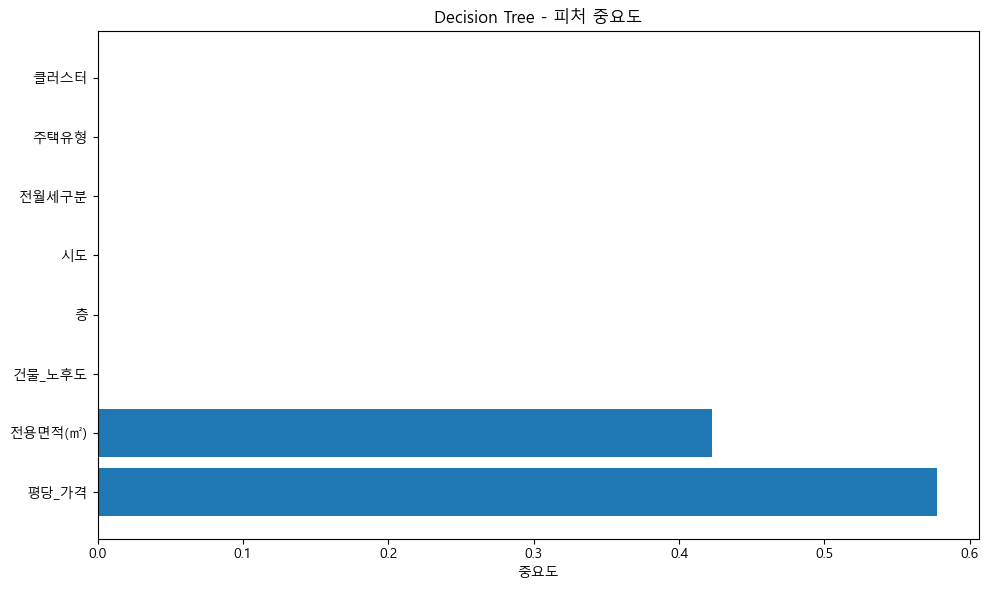

In [59]:
# 7. 최고 모델 상세 분석
print("\n7. 최고 모델 상세 분석")
print("-" * 50)

# 피처 중요도 분석 (트리 기반 모델의 경우)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        '피처': feature_columns,
        '중요도': best_model.feature_importances_
    }).sort_values('중요도', ascending=False)
    
    print("피처 중요도 순위:")
    for idx, row in feature_importance.iterrows():
        print(f"  {row['피처']}: {row['중요도']:.3f}")
    
    # 피처 중요도 시각화
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['피처'], feature_importance['중요도'])
    plt.title(f'{best_model_name} - 피처 중요도')
    plt.xlabel('중요도')
    plt.tight_layout()
    plt.show()



8. 모델 성능 시각화
--------------------------------------------------


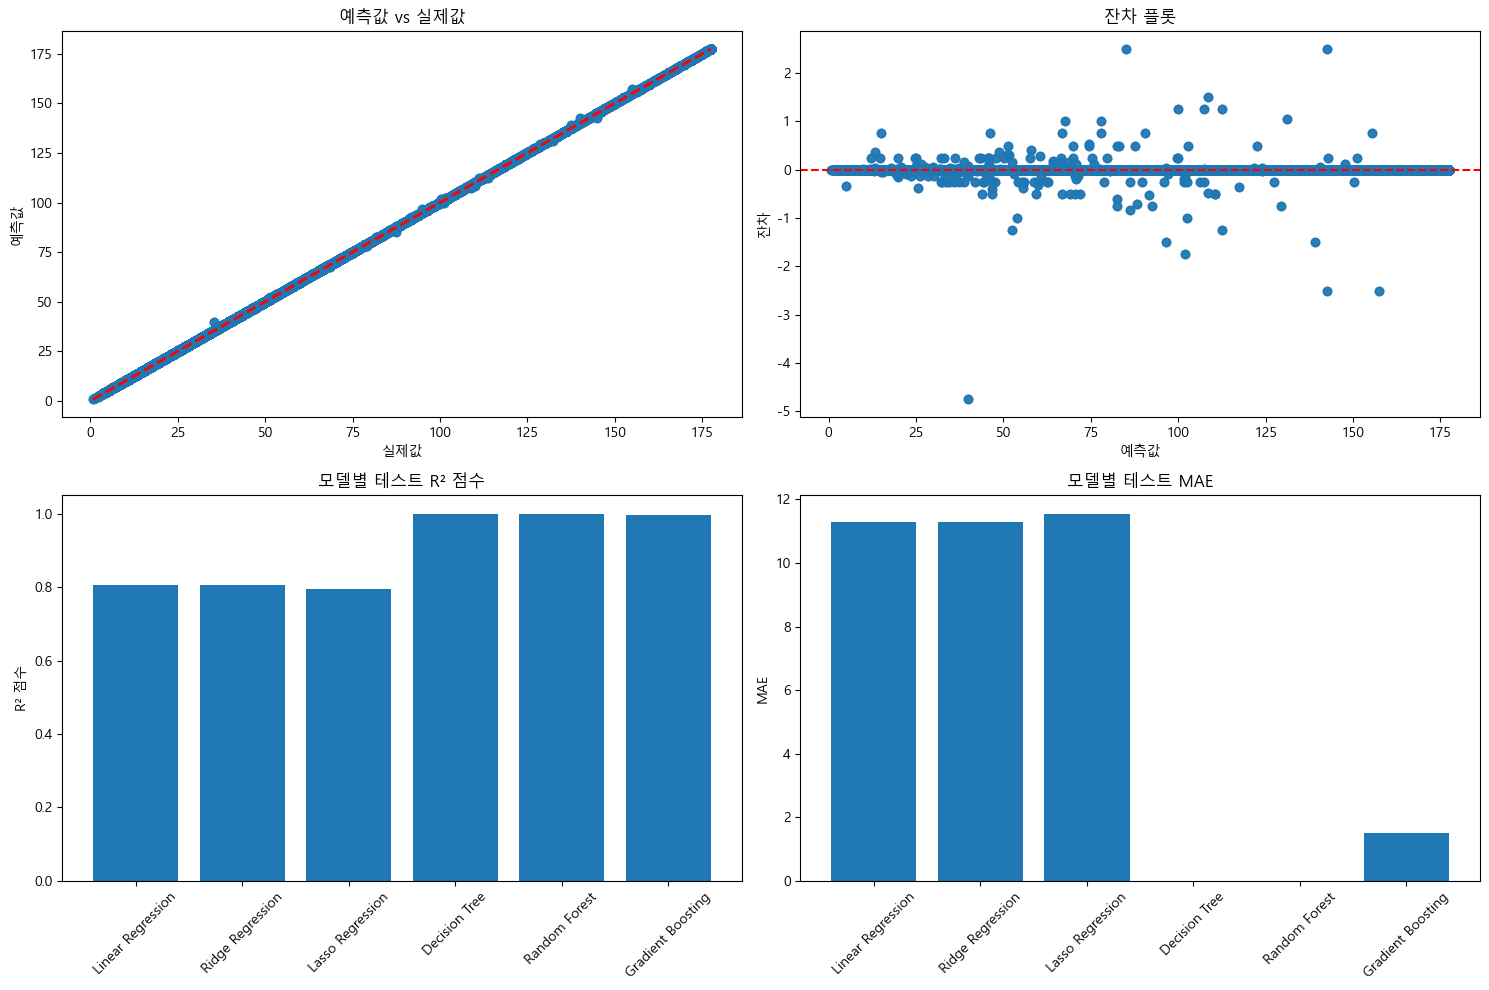

In [60]:
# 8. 모델 성능 시각화
print("\n8. 모델 성능 시각화")
print("-" * 50)

# 예측 vs 실제값 산점도
y_pred_best = best_model.predict(X_test)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 예측 vs 실제값
axes[0, 0].scatter(y_test, y_pred_best, alpha=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('실제값')
axes[0, 0].set_ylabel('예측값')
axes[0, 0].set_title('예측값 vs 실제값')

# 잔차 플롯
residuals = y_test - y_pred_best
axes[0, 1].scatter(y_pred_best, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('예측값')
axes[0, 1].set_ylabel('잔차')
axes[0, 1].set_title('잔차 플롯')

# 모델 성능 비교 (R² 점수)
axes[1, 0].bar(performance_df['모델'], performance_df['Test R²'])
axes[1, 0].set_title('모델별 테스트 R² 점수')
axes[1, 0].set_ylabel('R² 점수')
axes[1, 0].tick_params(axis='x', rotation=45)

# 모델 성능 비교 (MAE)
axes[1, 1].bar(performance_df['모델'], performance_df['Test MAE'])
axes[1, 1].set_title('모델별 테스트 MAE')
axes[1, 1].set_ylabel('MAE')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [61]:
# 9. 클러스터별 예측 성능 분석
print("\n9. 클러스터별 예측 성능 분석")
print("-" * 50)

# 테스트 데이터에 예측값과 클러스터 정보 추가
test_results = X_test.copy()
test_results['실제값'] = y_test
test_results['예측값'] = y_pred_best
test_results['오차'] = abs(y_test - y_pred_best)

# 클러스터별 성능 분석
cluster_performance = test_results.groupby('클러스터').agg({
    '실제값': ['mean', 'std'],
    '예측값': ['mean', 'std'],
    '오차': ['mean', 'std']
}).round(2)

cluster_performance.columns = ['_'.join(col).strip() for col in cluster_performance.columns]
print("클러스터별 예측 성능:")
print(cluster_performance)


9. 클러스터별 예측 성능 분석
--------------------------------------------------
클러스터별 예측 성능:
      실제값_mean  실제값_std  예측값_mean  예측값_std  오차_mean  오차_std
클러스터                                                       
0.0      56.92    31.34     56.92    31.34      0.0    0.01
1.0      83.17    40.76     83.17    40.76      0.0    0.03


In [62]:
# 10. 예측 함수 구현
print("\n10. 예측 함수 구현")
print("-" * 50)

def predict_living_cost(area, building_age, floor, lease_type, house_type, sido, cluster_id, 
                       model=best_model, encoders=label_encoders):
    """
    생활비 예측 함수
    
    Parameters:
    - area: 전용면적(㎡)
    - building_age: 건물 노후도(년)
    - floor: 층수
    - lease_type: 전월세 구분 ('전세', '월세')
    - house_type: 주택유형 ('아파트', '연립다세대')
    - sido: 시도명
    - cluster_id: 클러스터 ID (0 또는 1)
    """
    
    # 입력 데이터 준비
    input_data = pd.DataFrame({
        '전용면적(㎡)': [area],
        '건물_노후도': [building_age],
        '층': [floor],
        '평당_가격': [0],  # 임시값, 실제로는 계산 필요
        '전월세구분': [lease_type],
        '주택유형': [house_type],
        '시도': [sido],
        '클러스터': [cluster_id]
    })
    
    # 평당 가격 추정 (간단한 추정식 사용)
    estimated_monthly_cost = 50  # 기본값
    input_data['평당_가격'] = estimated_monthly_cost / (area * 0.3025)
    
    # 범주형 변수 인코딩
    for col in categorical_columns:
        if col in encoders:
            try:
                input_data[col] = encoders[col].transform(input_data[col].astype(str))
            except ValueError:
                # 새로운 카테고리인 경우 가장 빈번한 값으로 대체
                input_data[col] = 0
    
    # 예측
    prediction = model.predict(input_data[feature_columns])[0]
    
    return prediction

# 예측 함수 테스트
test_prediction = predict_living_cost(
    area=60, building_age=10, floor=5, 
    lease_type='월세', house_type='아파트', 
    sido='서울특별시', cluster_id=1
)

print(f"예측 테스트 결과: {test_prediction:.1f}만원")


10. 예측 함수 구현
--------------------------------------------------
예측 테스트 결과: 50.0만원


In [63]:
# 11. 모델 저장
print("\n11. 모델 저장")
print("-" * 50)

# 최고 성능 모델 저장
model_save_path = '../data/best_model.pkl'
joblib.dump(best_model, model_save_path)
print(f"최고 성능 모델 저장 완료: {model_save_path}")

# 인코더 저장
encoder_save_path = '../data/label_encoders.pkl'
joblib.dump(label_encoders, encoder_save_path)
print(f"라벨 인코더 저장 완료: {encoder_save_path}")

# 모델 정보 저장
model_info = {
    "모델명": best_model_name,
    "테스트_R2": model_results[best_model_name]['test_r2'],
    "테스트_MAE": model_results[best_model_name]['test_mae'],
    "피처_컬럼": feature_columns,
    "타겟_컬럼": target_column,
    "학습_데이터_크기": len(X_train),
    "테스트_데이터_크기": len(X_test)
}


11. 모델 저장
--------------------------------------------------
최고 성능 모델 저장 완료: ../data/best_model.pkl
라벨 인코더 저장 완료: ../data/label_encoders.pkl


In [64]:
import json
with open('../data/model_info.json', 'w', encoding='utf-8') as f:
    json.dump(model_info, f, ensure_ascii=False, indent=2)

print("모델 정보 저장 완료: model_info.json")

# 12. 결과 요약
print("\n12. 결과 요약")
print("-" * 50)

print(f"최고 성능 모델: {best_model_name}")
print(f"테스트 R² 점수: {model_results[best_model_name]['test_r2']:.3f}")
print(f"테스트 MAE: {model_results[best_model_name]['test_mae']:.2f}만원")
print(f"학습 데이터 크기: {len(X_train):,}건")
print(f"테스트 데이터 크기: {len(X_test):,}건")

print("\n생성된 파일:")
print("  - best_model.pkl (학습된 모델)")
print("  - label_encoders.pkl (라벨 인코더)")
print("  - model_info.json (모델 정보)")
print("  - 13_feature_importance.png (피처 중요도)")
print("  - 14_model_performance.png (모델 성능)")

print("\n생활비 예측 모델 구축 완료!") 

모델 정보 저장 완료: model_info.json

12. 결과 요약
--------------------------------------------------
최고 성능 모델: Decision Tree
테스트 R² 점수: 1.000
테스트 MAE: 0.00만원
학습 데이터 크기: 4,623,737건
테스트 데이터 크기: 1,155,935건

생성된 파일:
  - best_model.pkl (학습된 모델)
  - label_encoders.pkl (라벨 인코더)
  - model_info.json (모델 정보)
  - 13_feature_importance.png (피처 중요도)
  - 14_model_performance.png (모델 성능)

생활비 예측 모델 구축 완료!


In [ ]:


# diversity_df 정의
# 다양성 분석을 위한 데이터 로딩 및 지수 계산

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

print("=== diversity_df 정의 및 다양성 지수 계산 ===")

# 2024년 3월 상가 데이터 로딩
try:
    df_march = df_03
    print(f"2024년 3월 데이터 로딩 완료: {len(df_march):,}개 상가")
except:
    try:
        df_march = df_03
        print(f"2024년 3월 데이터 로딩 완료: {len(df_march):,}개 상가")
    except Exception as e:
        print(f"데이터 로딩 실패: {e}")
        print("파일 경로를 확인해주세요.")

# 다양성 지수 계산 함수들 정의
def calculate_shannon_diversity(series):
    """섀넌 다양성 지수 계산"""
    if len(series) == 0:
        return 0
    proportions = series.value_counts(normalize=True)
    return -sum(proportions * np.log(proportions + 1e-10))

def calculate_simpson_diversity(series):
    """심슨 다양성 지수 계산 (1 - D)"""
    if len(series) == 0:
        return 0
    proportions = series.value_counts(normalize=True)
    return 1 - sum(proportions ** 2)

def calculate_hhi(series):
    """허핀달-허쉬만 지수 계산"""
    if len(series) == 0:
        return 0
    proportions = series.value_counts(normalize=True)
    return sum(proportions ** 2) * 10000

def calculate_evenness(series):
    """균등도 계산 (J' = H'/ln(S))"""
    shannon = calculate_shannon_diversity(series)
    unique_count = series.nunique()
    if unique_count <= 1:
        return 0
    return shannon / np.log(unique_count)

# 지역별 다양성 지수 계산
diversity_results = []

for region in df_march['시도명'].unique():
    region_data = df_march[df_march['시도명'] == region]
    
    if len(region_data) == 0:
        continue
    
    # 업종별 분포 분석
    business_counts = region_data['상권업종대분류명'].value_counts()
    total_businesses = len(region_data)
    
    # 다양성 지수들 계산
    shannon_div = calculate_shannon_diversity(region_data['상권업종대분류명'])
    simpson_div = calculate_simpson_diversity(region_data['상권업종대분류명'])
    hhi_index = calculate_hhi(region_data['상권업종대분류명'])
    evenness = calculate_evenness(region_data['상권업종대분류명'])
    
    # 주요 업종 (가장 많은 업종)
    dominant_business = business_counts.index[0]
    dominant_ratio = business_counts.iloc[0] / total_businesses
    
    diversity_results.append({
        '시도명': region,
        '전체상가수': total_businesses,
        '업종수': region_data['상권업종대분류명'].nunique(),
        '섀넌다양성지수': shannon_div,
        '심슨다양성지수': simpson_div,
        'HHI지수': hhi_index,
        '역HHI지수': 1 / hhi_index if hhi_index > 0 else 0,
        '균등도': evenness,
        '주요업종': dominant_business,
        '주요업종비율': dominant_ratio
    })

# DataFrame으로 변환
diversity_df = pd.DataFrame(diversity_results)
diversity_df = diversity_df.sort_values('섀넌다양성지수', ascending=False).reset_index(drop=True)

print("diversity_df 정의 완료")
print(f"분석 대상 지역 수: {len(diversity_df)}")
print("\n상위 5개 지역:")
print(diversity_df.head(5)[['시도명', '섀넌다양성지수', 'HHI지수', '균등도']].round(4))
print("="*50)

=== diversity_df 정의 및 다양성 지수 계산 ===
2024년 3월 데이터 로딩 완료: 2,444,338개 상가
diversity_df 정의 완료
분석 대상 지역 수: 17

상위 5개 지역:
       시도명  섀넌다양성지수      HHI지수     균등도
0    서울특별시   1.9413  1757.2535  0.8431
1  세종특별자치시   1.9219  1852.9423  0.8347
2      경기도   1.9081  1875.0155  0.8287
3  제주특별자치도   1.8921  1968.1907  0.8217
4    인천광역시   1.8752  1994.4188  0.8144
